## CFG & import & scoring func

In [ ]:
!pip install colorama
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### CFG

In [ ]:
#CONFIG

CFG_DEBUG = True
CFG_SUBMIT = False
CFG_RETRAIN = False
CFG_is_Colab = True

In [ ]:
import os

if CFG_is_Colab:
    FP_INPUT_DIR = '/content/drive/MyDrive/kaggle/single-cell-competition/data/input/'
    FP_OUTPUT_DIR = '/content/drive/MyDrive/kaggle/single-cell-competition/data/output/'
    
    from google.colab import drive
    drive.mount('/content/drive')
else:
    FP_INPUT_DIR = '../input/'
    FP_OUTPUT_DIR = './'


FP_SPARSE_DATA = os.path.join(FP_INPUT_DIR, "multimodal-single-cell-as-sparse-matrix/")
FP_PCA_DATA = os.path.join(FP_INPUT_DIR, "single-cell-multi-svd-pkl/") 

FP_CELL_METADATA = os.path.join(FP_SPARSE_DATA,"metadata.parquet")
FP_CELL_METADATA_CSV = os.path.join(FP_SPARSE_DATA,"metadata.csv")

FP_CITE_TRAIN_INPUTS_VALUES = os.path.join(FP_SPARSE_DATA,"train_cite_inputs_values.sparse.npz")
FP_CITE_TRAIN_INPUTS_IDXCOL = os.path.join(FP_SPARSE_DATA,"train_cite_inputs_idxcol.npz")
FP_CITE_TRAIN_TARGETS_VALUES = os.path.join(FP_SPARSE_DATA,"train_cite_targets_values.sparse.npz")
FP_CITE_TRAIN_TARGETS_IDXCOL = os.path.join(FP_SPARSE_DATA,"train_cite_targets_idxcol.npz")
FP_CITE_TEST_INPUTS_VALUES = os.path.join(FP_SPARSE_DATA,"test_cite_inputs_values.sparse.npz")
FP_CITE_TEST_INPUTS_IDXCOL = os.path.join(FP_SPARSE_DATA,"test_cite_inputs_idxcol.npz")

FP_MULTI_TRAIN_INPUTS_VALUES = os.path.join(FP_SPARSE_DATA,"train_multi_inputs_values.sparse.npz")
FP_MULTI_TRAIN_INPUTS_IDXCOL = os.path.join(FP_SPARSE_DATA,"train_multi_inputs_idxcol.npz")
FP_MULTI_TRAIN_TARGETS_VALUES = os.path.join(FP_SPARSE_DATA,"train_multi_targets_values.sparse.npz")
FP_MULTI_TRAIN_TARGETS_IDXCOL = os.path.join(FP_SPARSE_DATA,"train_multi_targets_idxcol.npz")
FP_MULTI_TEST_INPUTS_VALUES = os.path.join(FP_SPARSE_DATA,"test_multi_inputs_values.sparse.npz")
FP_MULTI_TEST_INPUTS_IDXCOL = os.path.join(FP_SPARSE_DATA,"test_multi_inputs_idxcol.npz")

FP_SUBMISSION = os.path.join(FP_SPARSE_DATA,"sample_submission.parquet")
FP_EVALUATION = os.path.join(FP_SPARSE_DATA,"evaluation.parquet")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### import

In [ ]:
from tables.parameters import MAX_COLUMNS
import os, gc, pickle, warnings, math
import pandas as pd
pd.set_option('display.max_columns',100)
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os,gc,time,random
from tqdm.notebook import tqdm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

import scipy
import scipy.sparse
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix, lil_matrix

from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

### The scoring function (from AmbrosM)

This competition has a special metric: For every row, it computes the Pearson correlation between y_true and y_pred, and then all these correlation coefficients are averaged.

In [ ]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)


### def save()
フォルダが存在していない場合も、新規作成して保存してくれる。
存在している場合は、ファイルを上書き保存する。
pickle, numpyいずれの場合も可。

In [ ]:
def save(dir_path, filename, file_content, mode='wb'):
    os.makedirs(dir_path, exist_ok=True)
    with open(os.path.join(dir_path, filename), mode) as f:
        if type(arr) == np.ndarray: np.save(f,file_content)
        else: pickle.dump(file_content,f)

## content

#### approaching from RNA&DNA
* **アイデア**
    
    あるDNAには、対応するRNAがあって、あるRNAには対応するproteinがあり、対応しない遺伝情報は全く関係しないらしい。そこから着想を得て、targetのカラムごとに必要なtrain inputsだけ抽出してきて、predictに使えばいいのではないか、との仮説を立て、trainしてみた。

* **結果**

    必要そうなinputsを抽出したとしても、スコアにそれほどの変化は見られなかった。むしろスコアが下がったりした。実験の関係で、厳密な遺伝情報以外にも、batch effectsやノイズなどがかなり予測に寄与していそうだと感じた。つまり、inputs, targetsともにこのようなノイズなどを含んだ値であって、それら同士での回帰を考えるから、ノイズを取り除こうとしても精度が上がるとは限らない、ということだ。

In [ ]:
train_inputs = scipy.sparse.load_npz(FP_MULTI_TRAIN_INPUTS_VALUES)
type(train_inputs)

scipy.sparse.csr.csr_matrix

In [ ]:
%%time


train_inputs = scipy.sparse.load_npz(FP_MULTI_TRAIN_INPUTS_VALUES)
train_inputs = csc_matrix(train_inputs)
train_inputs

CPU times: user 1min 42s, sys: 7.71 s, total: 1min 50s
Wall time: 2min


<105942x228942 sparse matrix of type '<class 'numpy.float32'>'
	with 607301546 stored elements in Compressed Sparse Column format>

In [ ]:
train_targets = scipy.sparse.load_npz(FP_MULTI_TRAIN_TARGETS_VALUES)
train_targets = csr_matrix(train_targets)
print(train_targets)

<105942x23418 sparse matrix of type '<class 'numpy.float32'>'
	with 407024875 stored elements in Compressed Sparse Row format>

In [ ]:
print(inputs_cols[561:563])
print(indices[2])

['chr10:103508876-103509697' 'chr10:103526695-103527579']
9b4a87e22ad0


In [ ]:
chr19_list = [col for col in inputs_cols if 'chr17:4' in col]
chr19_list

In [ ]:
targets_cols = np.load(FP_MULTI_TRAIN_TARGETS_IDXCOL,allow_pickle=True)["columns"]
print(targets_cols.shape)

(23418,)


In [ ]:
%%time

train_cite_target = pd.read_hdf(CFG.input_dir + 'open-problems-multimodal/train_cite_targets.h5',start=0,stop=30)

list = [col for col in train_cite_target.columns if 'CD' not in col]
list

CPU times: user 10.2 ms, sys: 4.23 ms, total: 14.4 ms
Wall time: 19.7 ms


['HLA-A-B-C',
 'TIGIT',
 'Mouse-IgG1',
 'Mouse-IgG2a',
 'Mouse-IgG2b',
 'Rat-IgG2b',
 'Podoplanin',
 'IgM',
 'KLRG1',
 'HLA-DR',
 'CX3CR1',
 'integrinB7',
 'TCR',
 'Rat-IgG1',
 'Rat-IgG2a',
 'FceRIa',
 'IgD',
 'TCRVa7.2',
 'TCRVd2',
 'LOX-1',
 'HLA-E']

In [ ]:
%%time
X_columns = np.load(FP_CITE_TRAIN_INPUTS_IDXCOL,allow_pickle=True)["columns"]
col_list = [col for col in X_columns]
col_list

In [ ]:
imp_list = []
for ycol in y_columns:
    for xcol in X_columns:
        if ycol in xcol:
            imp_list.append(xcol)
imp_list

In [ ]:
%%time
X_columns = np.load(FP_MULTI_TRAIN_INPUTS_IDXCOL,allow_pickle=True)["columns"]
# col_list = [col for col in X_columns if 'chr' not in col]
# col_list
X_columns = list(X_columns)

CPU times: user 114 ms, sys: 35.7 ms, total: 149 ms
Wall time: 150 ms


In [ ]:
import re


re.sub(r':.*','',t)
ch_set = set([re.sub(r':.*','',col) for col in X_columns])

print(f'length: {len(ch_set)}')
print(ch_set)

length: 37
{'chr15', 'chr10', 'KI270726.1', 'chr21', 'chr9', 'chr2', 'KI270731.1', 'GL000218.1', 'chr19', 'KI270728.1', 'KI270734.1', 'chr14', 'chr3', 'chrY', 'GL000219.1', 'chr6', 'chr17', 'chr11', 'chr18', 'chr7', 'GL000195.1', 'chr16', 'chr8', 'GL000205.2', 'chrX', 'KI270727.1', 'KI270711.1', 'chr12', 'chr13', 'chr1', 'KI270721.1', 'chr4', 'chr20', 'chr5', 'KI270713.1', 'chr22', 'GL000194.1'}


##### feature selction with catboost

In [ ]:
inputs_cols = np.load(FP_MULTI_TRAIN_INPUTS_IDXCOL,allow_pickle=True)["columns"]
targets_cols = np.load(FP_MULTI_TRAIN_TARGETS_IDXCOL,allow_pickle=True)["columns"]
indices = np.load(FP_MULTI_TRAIN_INPUTS_IDXCOL,allow_pickle=True)["index"]

###### searching for DNA & RNA

at first, we are focusing on these.

* [AACS ; ENSG00000081760](https://asia.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000081760;r=12:125065434-125143333)
    * Chromosome 12: 125065434-125143333  
* [ELOVL5 ; ENSG00000012660](https://asia.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000012660;r=6:53267398-53349179)
    * Chromosome 6: 53267398-53349179
* [RASGRF2 ; ENSG00000113319](https://asia.ensembl.org/Homo_sapiens/Gene/Summary?g=ENSG00000113319;r=5:80960363-81230162)
    * Chromosome 5: 80960363-81230162
```
>>>targets_cols[[9,10000,18000]]
['ENSG00000081760' 'ENSG00000012660' 'ENSG00000113319']
```

In [ ]:
import re

chr12_DNA_list = [col for col in inputs_cols if 'chr12:' in col]
chr6_DNA_list = [col for col in inputs_cols if 'chr6:' in col]
chr5_DNA_list = [col for col in inputs_cols if 'chr5:8' in col]
chr5_DNA_list

In [ ]:
RNA_of_ELOVL5 = ['ENSG00000012660']
DNA_of_ELOVL5 = [
    'chr6:53258500-53259336',
    'chr6:53287338-53288266',
    'chr6:53290329-53291181',
    'chr6:53293865-53294745',
    'chr6:53300738-53301606',
    'chr6:53303398-53304276',
    'chr6:53309282-53310198',
    'chr6:53310663-53311459',
    'chr6:53312114-53313027',
    'chr6:53313613-53314421',
    'chr6:53320700-53321513',
    'chr6:53322432-53323258',
    'chr6:53326420-53327312',
    'chr6:53333709-53334499',
    'chr6:53335358-53336225',
    'chr6:53342259-53342630',
    'chr6:5334788-5335669',
    'chr6:53348542-53349375',
    'chr6:53358965-53359855',
    ]
RNA_of_AACS = ['ENSG00000081760']
DNA_of_AACS = [
    'chr12:125064988-125065872',
    'chr12:125066881-125067764',
    'chr12:12508357-12509256',
    'chr12:125098713-125099544',
    'chr12:125104055-125104483',
    'chr12:125115190-125116135',
    'chr12:125120910-125121798',
    'chr12:125132465-125133327',
    'chr12:125177967-125178827',
    ]
RNA_of_RASGRF2 = ['ENSG00000113319']
DNA_of_RASGRF2 = [
    'chr5:80960112-80960996',
    'chr5:80985372-80986240',
    'chr5:81006706-81007607',
    'chr5:81105037-81105844',
    'chr5:81108169-81109077',
    'chr5:81133822-81134737',
    'chr5:81165259-81166135',
    'chr5:81172459-81173335',
    'chr5:81174033-81174906',
    'chr5:81181435-81182279',
    'chr5:81194756-81195654',
    'chr5:81206843-81207692',
    'chr5:81221653-81222570',
    'chr5:81225208-81226105',
    'chr5:81230204-81231049',
    ]
RNA_of_CD27 = [col for col in inputs_cols if 'CD27' in col]
RNA_of_CD36 = ['ENSG00000081760_AACS']
RNA_of_CD23 = [col for col in inputs_cols if 'ENSG00000104921' in col]
RNA_of_HLA = [col for col in inputs_cols if 'ENSG00000206503' in col]
Protein_selected = ['CD27', 'CD36', 'CD23','HLA-A-B-C']

###### train cite


In [ ]:
inputs_cols = np.load(FP_CITE_TRAIN_INPUTS_IDXCOL,allow_pickle=True)["columns"]
targets_cols = np.load(FP_CITE_TRAIN_TARGETS_IDXCOL,allow_pickle=True)["columns"]
indices = np.load(FP_CITE_TRAIN_INPUTS_IDXCOL,allow_pickle=True)["index"]

In [ ]:
# 'ENSG00000139193' in
[col for col in inputs_cols if '' in col]

['ENSG00000206503_HLA-A']

In [ ]:
targets_cols

array(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c',
       'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7', 'CD105', 'CD49f', 'CD194',
       'CD4', 'CD44', 'CD14', 'CD16', 'CD25', 'CD45RO', 'CD279', 'TIGIT',
       'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b', 'CD20',
       'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM', 'CD5', 'CD195',
       'CD32', 'CD196', 'CD185', 'CD103', 'CD69', 'CD62L', 'CD161',
       'CD152', 'CD223', 'KLRG1', 'CD27', 'CD107a', 'CD95', 'CD134',
       'HLA-DR', 'CD1c', 'CD11b', 'CD64', 'CD141', 'CD1d', 'CD314',
       'CD35', 'CD57', 'CD272', 'CD278', 'CD58', 'CD39', 'CX3CR1', 'CD24',
       'CD21', 'CD11a', 'CD79b', 'CD244', 'CD169', 'integrinB7', 'CD268',
       'CD42b', 'CD54', 'CD62P', 'CD119', 'TCR', 'Rat-IgG1', 'Rat-IgG2a',
       'CD192', 'CD122', 'FceRIa', 'CD41', 'CD137', 'CD163', 'CD83',
       'CD124', 'CD13', 'CD2', 'CD226', 'CD29', 'CD303', 'CD49b', 'C

In [ ]:
from catboost import CatBoostRegressor
params = {'learning_rate': 0.1, 
          'depth': 7, 
          'l2_leaf_reg': 4, 
          'loss_function': 'MultiRMSE', 
          'eval_metric': 'MultiRMSE', 
          'task_type': 'CPU', 
          'iterations': 200,
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bayesian', 
          'allow_const_label': True, 
          'random_state': 1
         }
model = CatBoostRegressor(**params)

In [ ]:
def slice_sparse_matrix_by_columns_list(sparse_matrix, all_columns, sub_columns):
    '''
    # examples of use:
    >>> sparse_matrix = csc_matrix(scipy.sparse.load_npz(FP_MULTI_TRAIN_INPUTS_VALUES))
    >>> all_columns = np.load(FP_MULTI_TRAIN_INPUTS_IDXCOL,allow_pickle=True)["columns"]
    >>> sub_columns = ['chr6:53258500-53259336', 'chr6:53287338-53288266',]
    >>> chr6_data = slice_sparse_matrix_by_columns_list(sparse_matrix, all_columns, sub_columns)
    '''
    assert sparse_matrix.shape[1] == len(all_columns), 'column list size is not appropriate'
    dic = dict((k,v) for v,k in enumerate(all_columns))
    sub_columns_indices = [dic.get(col) for col in sub_columns]
    return sparse_matrix[:,sub_columns_indices]


def drop_columns_of_sparse(sparse_matrix, all_columns, drop_columns):
    assert sparse_matrix.shape[1] == len(all_columns), 'column list size is not appropriate'
    dic = dict((k,v) for v,k in enumerate(all_columns))
    remaining_columns = [col for col in all_columns if col not in drop_columns]
    remaining_columns_indices = [dic.get(col) for col in remaining_columns]
    return sparse_matrix[:,remaining_columns_indices]

In [ ]:
# train_inputs = drop_columns_of_sparse(train_inputs,inputs_cols,DNA_random)
# print(f'inputs shape: {train_inputs.shape}')

# train_targets = drop_columns_of_sparse(train_targets,targets_cols,RNA_of_ELOVL5+RNA_of_AACS)
# print(f'targets shape: {train_targets.shape}')



targets shape: (105942, 23416)


In [ ]:
# train_inputs = scipy.sparse.load_npz(FP_CITE_TRAIN_INPUTS_VALUES)
# train_targets = scipy.sparse.load_npz(FP_CITE_TRAIN_TARGETS_VALUES)
def row_col_select(train_inputs,train_targets,inputs_cols,targets_cols,seed, num_of_inputs_columns=50, num_of_targets_columns=4):
    '''
    # Example of use:
    ```
    # read data
    train_inputs = scipy.sparse.load_npz(FP_CITE_TRAIN_INPUTS_VALUES)
    train_targets = scipy.sparse.load_npz(FP_CITE_TRAIN_TARGETS_VALUES)
    inputs_cols = np.load(FP_CITE_TRAIN_INPUTS_IDXCOL,allow_pickle=True)["columns"]
    targets_cols = np.load(FP_CITE_TRAIN_TARGETS_IDXCOL,allow_pickle=True)["columns"]

    # select inputs columns, targets columns, indices
    RNA_random,Protein_random,selected_indices = row_col_select(train_inputs,train_targets,inputs_cols,targets_cols,seed, num_of_inputs_columns=50, num_of_targets_columns=3)
    ```
    '''
    np.random.seed(seed=seed) #40
    print(f'train_inputs shape: {train_inputs.shape}')
    print(f'train_targets shape: {train_targets.shape}')

    # column selection
    column_idx_inputs = np.arange(train_inputs.shape[1])
    np.random.shuffle(column_idx_inputs)
    RNA_random = list(inputs_cols[column_idx_inputs[:num_of_inputs_columns]])
    print(f'RNA_random: {RNA_random}')
    column_idx_targets = np.arange(train_targets.shape[1])
    np.random.shuffle(column_idx_targets)
    Protein_random = list(targets_cols[column_idx_targets[:num_of_targets_columns]])
    print(f'Protein_random: {Protein_random}')

    # row selection
    row_idx_inputs = np.arange(train_inputs.shape[0])
    np.random.shuffle(row_idx_inputs)
    selected_indices = list(row_idx_inputs[:])
    print(f'selected_indices: {selected_indices}\n')
    return RNA_random,Protein_random,selected_indices

In [ ]:
score_list = []
for seed in range(10):
    RNA_random,Protein_random,selected_indices = row_col_select(train_inputs,train_targets,inputs_cols,targets_cols,seed=seed,num_of_inputs_columns=50, num_of_targets_columns=4)
    X = slice_sparse_matrix_by_columns_list(train_inputs, inputs_cols, RNA_random+RNA_random)  # RNA_random+RNA_of_CD23+RNA_of_CD27+RNA_of_CD36 + RNA_of_HLA
    y = slice_sparse_matrix_by_columns_list(train_targets, targets_cols, Protein_random) # 
    Xtr, Xva = train_test_split(X, shuffle=False,random_state=42)
    ytr, yva = train_test_split(y, shuffle=False,random_state=42)
    model.fit(Xtr.toarray(), ytr.toarray())
    del Xtr, ytr
    gc.collect()
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')
    preds = model.predict(Xva)
    # print(Back.YELLOW + Style.BRIGHT + f'score: {correlation_score(yva.toarray(),preds)}\n')
    r = correlation_score(yva.toarray(),preds)
    score_list.append(r)
    # get_score(yva,preds, score_title=f'RNA_random->Protein_random seed{seed}')

score_list

[0.05519091631347846,
 0.6139399421971468,
 0.9156141084552296,
 0.8241530510161789,
 0.01081126536719999,
 0.37201208040624023,
 0.9493352882808823,
 0.5189644254024341,
 0.9097308114679697,
 0.5992592840246393]

In [ ]:
%%time

# scores = {}
def get_score(yva,preds, score_title=None):
    counter = 0
    score = 0
    for i in range(yva.shape[0]):
        r = np.corrcoef(yva.toarray()[i], preds[i])[1,0]
        if not math.isnan(r):
            counter += 1
            score += r
    score = score/counter
    print(Back.YELLOW + Style.BRIGHT + f'score: {score}\n' + Style.RESET_ALL)
    if score_title:
        scores[score_title] = score
        print(scores)

# get_score(yva,preds)

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 15.5 µs


In [ ]:
import math

i = 32
print(np.corrcoef(yva.toarray()[i], preds[i])[0,1])

1.0


In [ ]:
for i in [31,32]:
    print(f'i={i},')
    print(preds[i])
    print(yva.toarray()[i])



i=31,
[1.2185552  3.55311075]
[4.294864 0.      ]
i=32,
[1.61447129 3.8064921 ]
[0.      5.32809]


###### train multi

In [ ]:
inputs_cols = np.load(FP_MULTI_TRAIN_INPUTS_IDXCOL,allow_pickle=True)["columns"]
targets_cols = np.load(FP_MULTI_TRAIN_TARGETS_IDXCOL,allow_pickle=True)["columns"]
indices = np.load(FP_MULTI_TRAIN_INPUTS_IDXCOL,allow_pickle=True)["index"]

In [ ]:
eval_ids = pd.read_parquet(FP_EVALUATION)
gene_dict = dict((k,v) for v,k in enumerate(targets_cols))

assert len(gene_dict) == len(targets_cols)
eval_ids_gene_num = eval_ids.gene_id.apply(lambda x:gene_dict.get(x, -1))

In [ ]:
display(eval_ids)
display(eval_ids_gene_num)
print(gene_dict)

In [ ]:
from catboost import CatBoostRegressor
params = {'learning_rate': 0.1, 
          'depth': 7, 
          'l2_leaf_reg': 4, 
          'loss_function': 'MultiRMSE', 
          'eval_metric': 'MultiRMSE', 
          'task_type': 'CPU', 
          'iterations': 200,
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bayesian', 
          'allow_const_label': True, 
          'random_state': 1
         }
model = CatBoostRegressor(**params)

In [ ]:
def slice_sparse_matrix_by_columns_list(sparse_matrix, all_columns, sub_columns):
    '''
    # examples of use:
    >>> sparse_matrix = csc_matrix(scipy.sparse.load_npz(FP_MULTI_TRAIN_INPUTS_VALUES))
    >>> all_columns = np.load(FP_MULTI_TRAIN_INPUTS_IDXCOL,allow_pickle=True)["columns"]
    >>> sub_columns = ['chr6:53258500-53259336', 'chr6:53287338-53288266',]
    >>> chr6_data = slice_sparse_matrix_by_columns_list(sparse_matrix, all_columns, sub_columns)
    '''
    assert sparse_matrix.shape[1] == len(all_columns), 'column list size is not appropriate'
    dic = dict((k,v) for v,k in enumerate(all_columns))
    sub_columns_indices = [dic.get(col) for col in sub_columns]
    return sparse_matrix[:,sub_columns_indices]


def drop_columns_of_sparse(sparse_matrix, all_columns, drop_columns):
    assert sparse_matrix.shape[1] == len(all_columns), 'column list size is not appropriate'
    dic = dict((k,v) for v,k in enumerate(all_columns))
    remaining_columns = [col for col in all_columns if col not in drop_columns]
    remaining_columns_indices = [dic.get(col) for col in remaining_columns]
    return sparse_matrix[:,remaining_columns_indices]

In [ ]:
# train_inputs = drop_columns_of_sparse(train_inputs,inputs_cols,DNA_random)
# print(f'inputs shape: {train_inputs.shape}')

# train_targets = drop_columns_of_sparse(train_targets,targets_cols,RNA_of_ELOVL5+RNA_of_AACS)
# print(f'targets shape: {train_targets.shape}')



targets shape: (105942, 23416)


In [ ]:
# train_inputs = scipy.sparse.load_npz(FP_MULTI_TRAIN_INPUTS_VALUES)
# train_targets = scipy.sparse.load_npz(FP_MULTI_TRAIN_TARGETS_VALUES)


# column selection
column_idx_inputs = np.arange(train_inputs.shape[1])
np.random.shuffle(column_idx_inputs)
DNA_random = list(inputs_cols[column_idx_inputs[:30]])
print(f'DNA_random: {DNA_random}')
column_idx_targets = np.arange(train_targets.shape[1])
np.random.shuffle(column_idx_targets)
RNA_random = list(targets_cols[column_idx_targets[:50]])
print(f'RNA_random: {RNA_random}')

# row selection
row_idx_inputs = np.arange(train_inputs.shape[0])
np.random.shuffle(row_idx_inputs)
selected_indices = list(row_idx_inputs[:10000])
print(f'selected_indices: {selected_indices}')

DNA_random: ['chr5:59764315-59765128', 'chr15:38087199-38087906', 'chr20:41657384-41658291', 'chr3:30752715-30753601', 'chr2:85672385-85673266', 'chr7:103155286-103156220', 'chr19:56144163-56145071', 'chr15:31235111-31236014', 'chr21:42276429-42277339', 'chr1:44402244-44403149', 'chr9:83001283-83002129', 'chr1:161630788-161631712', 'chr17:38598292-38599154', 'chr3:69723072-69724007', 'chr11:61516633-61517451', 'chr22:36052316-36053199', 'chr4:139609348-139610168', 'chr13:51967590-51968519', 'chr16:20741301-20742095', 'chr2:113390110-113391021', 'chr7:143007657-143008557', 'chr17:76452778-76453591', 'chr5:158463757-158464663', 'chr6:130484753-130485578', 'chr1:27785649-27786581', 'chr14:35034081-35034917', 'chr17:59433453-59434255', 'chr16:73210402-73211320', 'chr7:98013162-98014069', 'chr5:80388087-80388871']
RNA_random: ['ENSG00000174839', 'ENSG00000285840', 'ENSG00000269958', 'ENSG00000100068', 'ENSG00000244055', 'ENSG00000083097', 'ENSG00000181234', 'ENSG00000271795', 'ENSG000002851

In [ ]:
X = slice_sparse_matrix_by_columns_list(train_inputs[selected_indices], inputs_cols, DNA_random)  # +DNA_of_AACS + DNA_of_ELOVL5 + DNA_of_RASGRF2
y = slice_sparse_matrix_by_columns_list(train_targets[selected_indices], targets_cols, RNA_of_AACS + RNA_of_ELOVL5+ RNA_of_RASGRF2) # +RNA_of_AACS+RNA_of_ELOVL5+RNA_of_RASGRF2
Xtr, Xva = train_test_split(X, shuffle=False,random_state=42)
ytr, yva = train_test_split(y, shuffle=False,random_state=42)
model.fit(Xtr.toarray(), ytr.toarray())
del Xtr, ytr
gc.collect()
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
preds = model.predict(Xva)


0:	learn: 3.2895871	total: 70.8ms	remaining: 14.1s
1:	learn: 3.2888618	total: 83.8ms	remaining: 8.3s
2:	learn: 3.2878297	total: 101ms	remaining: 6.62s
3:	learn: 3.2869341	total: 112ms	remaining: 5.5s
4:	learn: 3.2854762	total: 124ms	remaining: 4.83s
5:	learn: 3.2849790	total: 137ms	remaining: 4.43s
6:	learn: 3.2840170	total: 149ms	remaining: 4.11s
7:	learn: 3.2836358	total: 162ms	remaining: 3.89s
8:	learn: 3.2826780	total: 174ms	remaining: 3.7s
9:	learn: 3.2822534	total: 186ms	remaining: 3.54s
10:	learn: 3.2816569	total: 198ms	remaining: 3.4s
11:	learn: 3.2810969	total: 210ms	remaining: 3.29s
12:	learn: 3.2806690	total: 221ms	remaining: 3.18s
13:	learn: 3.2798877	total: 232ms	remaining: 3.08s
14:	learn: 3.2792140	total: 243ms	remaining: 3s
15:	learn: 3.2786823	total: 261ms	remaining: 3s
16:	learn: 3.2780121	total: 274ms	remaining: 2.95s
17:	learn: 3.2776576	total: 286ms	remaining: 2.89s
18:	learn: 3.2768257	total: 297ms	remaining: 2.83s
19:	learn: 3.2758159	total: 310ms	remaining: 2.79

In [ ]:
%%time
counter = 0
score = 0
scores = []
for i in range(yva.shape[0]):
    r = np.corrcoef(yva.toarray()[i], preds[i])[1,0]
    if not math.isnan(r):
        # print(r)
        counter += 1
        score += r
    # print(preds[i])
    # print(yva.toarray()[i])
score = score/counter
print(Back.YELLOW + Style.BRIGHT + f'score: {score}\n' + Style.RESET_ALL)
scores.append(score)
print(scores)

score: 0.8082883129860485

[0.8082883129860485]
CPU times: user 360 ms, sys: 924 µs, total: 361 ms
Wall time: 381 ms


In [ ]:
s = correlation_score(yva.toarray(),preds)
print(Back.YELLOW + Style.BRIGHT + f'score: {s}\n')

score: nan



In [ ]:
# scaler = StandardScaler()
# preds_norm = scaler.fit_transform(preds)
# preds_norm
# scaler = StandardScaler()
# yva_norm = scaler.fit_transform(yva.toarray())
# yva_norm
# se = 0
# for i in range(len(yva_norm)):
#     se += np.sum((yva_norm[i] - preds_norm[i])**2)
# se = se/len(yva_norm)
# se

array([[-0.36713081, -0.11140996],
       [ 0.58730196,  0.88408082],
       [-0.31565689,  0.22306886],
       ...,
       [-0.19886787, -0.49300837],
       [ 0.65880593,  0.78883683],
       [-0.08355543, -0.08335085]])

In [ ]:
import math

i = 32
print(np.corrcoef(yva.toarray()[i], preds[i])[0,1])

1.0


In [ ]:
for i in [31,32]:
    print(f'i={i},')
    print(preds[i])
    print(yva.toarray()[i])



i=31,
[1.2185552  3.55311075]
[4.294864 0.      ]
i=32,
[1.61447129 3.8064921 ]
[0.      5.32809]


#### look at score_df
score_df: citeseqのtargetsとinputsをランダムサンプリングして、catboostした時の相関係数を表す。
trainのコードは[boot_strap_train.ipynb](https://colab.research.google.com/drive/1HrCOR3b_mQKijcKRlTss02f-eTDeWgbI)を参照。

In [ ]:
import glob
import os

score_df = pd.DataFrame(index = [f'inputs seed{i}' for i in range(100,200)])
for f in glob.glob(FP_INPUT_DIR+'*.csv'):
    print(os.path.split(f)[1])
    tmp_df = pd.read_csv(f,index_col=0)
    # display(tmp_df.index)
    score_df = score_df.merge(tmp_df,left_index=True,right_index=True)
score_df

score_df_100-200&1120-1130.csv
score_df_100-200&1100-1110.csv
score_df_100-200&1110-1120.csv
score_df_100-200&1130-1140.csv


,protein seed1120,protein seed1121,protein seed1122,protein seed1123,protein seed1124,protein seed1125,protein seed1126,protein seed1127,protein seed1128,protein seed1129,...,protein seed1130,protein seed1131,protein seed1132,protein seed1133,protein seed1134,protein seed1135,protein seed1136,protein seed1137,protein seed1138,protein seed1139
inputs seed100,0.366561,0.873716,0.278172,0.942912,0.342590,0.743629,0.947587,0.472442,0.957329,0.889768,...,0.428587,0.958951,0.855676,0.605033,0.732437,0.679627,0.401052,0.847975,0.320421,0.206952
inputs seed101,0.344975,0.871669,0.273005,0.939441,0.354559,0.733369,0.947016,0.458156,0.957321,0.890914,...,0.427968,0.956642,0.849893,0.607200,0.725611,0.673866,0.405263,0.847704,0.291140,0.206227
inputs seed102,0.354245,0.866492,0.264176,0.932631,0.346839,0.740015,0.942312,0.482751,0.954743,0.893361,...,0.475014,0.960796,0.851662,0.609556,0.735367,0.679388,0.412415,0.851255,0.288205,0.207908
inputs seed103,0.343511,0.873831,0.266024,0.940719,0.370599,0.730534,0.948556,0.455986,0.960081,0.890607,...,0.442429,0.955040,0.865260,0.600961,0.730592,0.681154,0.392007,0.858631,0.291342,0.194682
inputs seed104,0.350490,0.862959,0.254068,0.940410,0.346174,0.720260,0.947716,0.462187,0.957675,0.892167,...,0.431682,0.955473,0.852984,0.615212,0.735581,0.667421,0.371778,0.857448,0.284248,0.208363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
inputs seed195,0.360847,0.866193,0.257096,0.934984,0.358383,0.733565,0.945871,0.480228,0.954860,0.890323,...,0.441412,0.959428,0.852477,0.605460,0.740972,0.676754,0.392940,0.854080,0.284649,0.199530
inputs seed196,0.355612,0.866007,0.269211,0.936556,0.351690,0.727987,0.952111,0.445600,0.955849,0.890307,...,0.416271,0.955770,0.854617,0.613829,0.731712,0.675108,0.404154,0.859709,0.299177,0.219495
inputs seed197,0.360674,0.866033,0.261041,0.940963,0.348197,0.728985,0.944559,0.430618,0.957433,0.886804,...,0.394421,0.952853,0.844867,0.620196,0.733173,0.673711,0.389423,0.850219,0.283691,0.199845
inputs seed198,0.349462,0.868151,0.263052,0.941085,0.345128,0.738288,0.954026,0.449354,0.956583,0.888543,...,0.422733,0.957303,0.862023,0.609772,0.738418,0.673809,0.394113,0.849082,0.284055,0.194410


In [ ]:


scaler = MinMaxScaler()
score_scaled = scaler.fit_transform(score_df)
score_scaled = pd.DataFrame(score_scaled, index=score_df.index,columns=score_df.columns)
score_scaled.agg(['max','min','mean','std'])

,protein seed1120,protein seed1121,protein seed1122,protein seed1123,protein seed1124,protein seed1125,protein seed1126,protein seed1127,protein seed1128,protein seed1129,protein seed1100,protein seed1101,protein seed1102,protein seed1103,protein seed1104,protein seed1105,protein seed1106,protein seed1107,protein seed1108,protein seed1109,protein seed1110,protein seed1111,protein seed1112,protein seed1113,protein seed1114,protein seed1115,protein seed1116,protein seed1117,protein seed1118,protein seed1119,protein seed1130,protein seed1131,protein seed1132,protein seed1133,protein seed1134,protein seed1135,protein seed1136,protein seed1137,protein seed1138,protein seed1139
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,0.437304,0.504855,0.455800,0.435182,0.432689,0.502680,0.544100,0.464210,0.495836,0.560889,0.480554,0.429650,0.473152,0.475437,0.453256,0.536501,0.422357,0.510646,0.544766,0.537438,0.592728,0.460613,0.472912,0.520840,0.460902,0.490273,0.482859,0.600571,0.442928,0.443104,0.463518,0.582006,0.484024,0.548820,0.505327,0.500012,0.514031,0.418926,0.515659,0.567170
std,0.218402,0.211775,0.176418,0.184055,0.211055,0.208945,0.215536,0.219855,0.181452,0.225793,0.205820,0.199921,0.201731,0.190501,0.220959,0.208308,0.206800,0.200735,0.184231,0.181708,0.197227,0.187533,0.207294,0.218407,0.216457,0.180228,0.194148,0.196764,0.193698,0.200499,0.234857,0.210003,0.210112,0.205557,0.209940,0.175127,0.202550,0.178268,0.208485,0.155121


In [ ]:
scaler = StandardScaler()
score_scaled = scaler.fit_transform(score_df)
score_scaled = pd.DataFrame(score_scaled, index=score_df.index,columns=score_df.columns)
score_scaled.agg(['max','min','mean','std'])

,protein seed1120,protein seed1121,protein seed1122,protein seed1123,protein seed1124,protein seed1125,protein seed1126,protein seed1127,protein seed1128,protein seed1129,protein seed1100,protein seed1101,protein seed1102,protein seed1103,protein seed1104,protein seed1105,protein seed1106,protein seed1107,protein seed1108,protein seed1109,protein seed1110,protein seed1111,protein seed1112,protein seed1113,protein seed1114,protein seed1115,protein seed1116,protein seed1117,protein seed1118,protein seed1119,protein seed1130,protein seed1131,protein seed1132,protein seed1133,protein seed1134,protein seed1135,protein seed1136,protein seed1137,protein seed1138,protein seed1139
max,2.589400e+00,2.349853e+00,3.100255e+00,3.084202e+00,2.701520e+00,2.392136e+00,2.125846e+00,2.449289e+00,2.792501e+00,1.954548e+00,2.536500e+00,2.867252e+00,2.624793e+00,2.767469e+00,2.486881e+00,2.236276e+00,2.807319e+00,2.450092e+00,2.483445e+00,2.558459e+00,2.075395e+00,2.890706e+00,2.555519e+00,2.204934e+00,2.503108e+00,2.842481e+00,2.677063e+00,2.040212e+00,2.890466e+00,2.791548e+00,2.295799e+00,2.000447e+00,2.468091e+00,2.205974e+00,2.368128e+00,2.869382e+00,2.411337e+00,3.275976e+00,2.334845e+00,2.804331e+00
min,-2.012371e+00,-2.395931e+00,-2.596645e+00,-2.376317e+00,-2.060452e+00,-2.417918e+00,-2.537118e+00,-2.122071e+00,-2.746377e+00,-2.496601e+00,-2.346586e+00,-2.159927e+00,-2.357276e+00,-2.508287e+00,-2.061650e+00,-2.588496e+00,-2.052633e+00,-2.556695e+00,-2.971875e+00,-2.972608e+00,-3.020451e+00,-2.468542e+00,-2.292856e+00,-2.396730e+00,-2.140029e+00,-2.734001e+00,-2.499601e+00,-3.067610e+00,-2.298208e+00,-2.221147e+00,-1.983560e+00,-2.785379e+00,-2.315257e+00,-2.683369e+00,-2.419130e+00,-2.869523e+00,-2.550576e+00,-2.361822e+00,-2.485816e+00,-3.674734e+00
mean,-8.656409e-15,3.979650e-14,-3.852474e-15,7.141399e-14,4.334311e-15,-1.174838e-14,-5.275780e-15,-4.027334e-16,-8.619216e-14,-9.899026e-16,2.433609e-15,-2.277956e-14,3.852474e-15,-1.778709e-14,-2.720046e-16,1.721956e-15,2.498168e-14,-3.137046e-14,3.668732e-15,1.236566e-14,-1.118539e-13,-4.980960e-14,-1.929568e-15,-1.012967e-14,-1.653566e-14,1.866896e-14,-4.848122e-14,1.263434e-15,-1.620037e-14,-1.365574e-16,-1.133538e-15,-8.014613e-15,-2.842171e-15,-5.986323e-15,-2.951139e-14,-1.235345e-14,4.936052e-15,-1.190673e-14,-4.922729e-15,-1.030287e-15
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00


#### read preds.npy and submit

In [ ]:
def set_cfg():
    import os
    import json
    f = open("/content/drive/MyDrive/api/kaggle.json", 'r')
    json_data = json.load(f)
    os.environ['KAGGLE_USERNAME'] = json_data['username']
    os.environ['KAGGLE_KEY'] = json_data['key']

def submit():
    !pip install kaggle
    !kaggle competitions submit -c open-problems-multimodal -f /content/drive/MyDrive/kaggle/single-cell-competition/data/output/submission.csv -m "Message"
def check_submissions():
    !kaggle competitions submissions -c open-problems-multimodal

In [ ]:
set_cfg()


In [ ]:
!kaggle kernels list

ref                                                            title                                            author                lastRunTime          totalVotes  
-------------------------------------------------------------  -----------------------------------------------  --------------------  -------------------  ----------  
cdeotte/test-data-leak-lb-boost                                Test Data Leak - LB Boost                        Chris Deotte          2022-11-04 20:10:46          48  
eraikako/data-science-and-mlops-in-industry-in-2022            Data Science and MLOps in Industry in 2022       Evgenia Raikakou      2022-11-05 01:04:50          34  
phongnguyen1/baselines-feature-selection-tuning                Baselines - Feature Selection - Tuning           Phong Nguyen          2022-11-05 00:31:39          28  
sandhyakrishnan02/what-changed-from-2021-to-2022-in-ml-and-ds  What Changed from 2021 to 2022 in ML and DS?     SandhyaKrishnan02     2022-11-04 15:27:45       

In [ ]:
from statistics import mean

cv_dict = {
    'x128y128':[.6683427933651053,.6684212506618523,.6684446198641047,.6676899623778351,.6677329566892636],
    'x16y16':[.6649735296662495,.6651023693611845,.6650551638550276,.6642788359405638,.6643589669500838],
    'x32y32':[.667465703452444,.6675560549573949,.667564044699356,.6667930750066633,.6668598800413362]
 }

for i in [16,32,128]:
    m = mean(cv_dict[f'x{i}y{i}'])
    print(f'mean {i}: {m}')

mean 16: 0.6647537731546218
mean 32: 0.6672477516314389
mean 128: 0.6681263165916322


##### Creating submission

We load the cells that will have to appear in submission.

In [ ]:
def convert_preds_to_submission(preds):
    # Read the table of rows and columns required for submission
    eval_ids = pd.read_parquet(FP_EVALUATION)

    # Convert the string columns to more efficient categorical types
    #eval_ids.cell_id = eval_ids.cell_id.apply(lambda s: int(s, base=16))
    eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
    eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())
    # Prepare an empty series which will be filled with predictions
    submission = pd.Series(name='target',
                        index=pd.MultiIndex.from_frame(eval_ids), 
                        dtype=np.float32)


    y_columns = np.load(FP_MULTI_TRAIN_TARGETS_IDXCOL,
                    allow_pickle=True)["columns"]

    test_index = np.load(FP_MULTI_TEST_INPUTS_IDXCOL,
                        allow_pickle=True)["index"]
                        
    cell_dict = dict((k,v) for v,k in enumerate(test_index)) 
    assert len(cell_dict)  == len(test_index)

    gene_dict = dict((k,v) for v,k in enumerate(y_columns))
    assert len(gene_dict) == len(y_columns)
    eval_ids_cell_num = eval_ids.cell_id.apply(lambda x:cell_dict.get(x, -1))
    eval_ids_gene_num = eval_ids.gene_id.apply(lambda x:gene_dict.get(x, -1))

    valid_multi_rows = (eval_ids_gene_num !=-1) & (eval_ids_cell_num!=-1)
    submission.iloc[valid_multi_rows] = preds[eval_ids_cell_num[valid_multi_rows].to_numpy(),
    eval_ids_gene_num[valid_multi_rows].to_numpy()]

    del eval_ids_cell_num, eval_ids_gene_num, valid_multi_rows, eval_ids, test_index, y_columns
    gc.collect()
    return submission

In [ ]:
def merge_with_cite(submission, cite_path=FP_INPUT_DIR + "msci-citeseq-keras-quickstart/submission.csv"):
    submission.reset_index(drop=True, inplace=True)
    submission.index.name = 'row_id'
    cite_submission = pd.read_csv(cite_path)
    cite_submission = cite_submission.set_index("row_id")
    cite_submission = cite_submission["target"]
    submission[submission.isnull()] = cite_submission[submission.isnull()]
    return submission

In [ ]:
import glob

for file_path in tqdm(list(glob.glob(FP_OUTPUT_DIR+'preds_*'))):
    file_name = os.path.basename(file_path)
    print(f'converting {file_name} ...')
    preds = np.load(FP_OUTPUT_DIR+file_name)
    %time submission = convert_preds_to_submission(preds)

    print('merging...')
    %time submission = merge_with_cite(submission,FP_INPUT_DIR+'5-5-msci22-ensembling-citeseq/submission.csv')
    
    print('saving...')
    file_name = file_name.replace('.npy','').replace('preds_','')
    %time submission.to_csv(FP_OUTPUT_DIR + f"submission_{file_name}.csv")
    del submission
    gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

converting preds_x64y64.npy ...
CPU times: user 30.4 s, sys: 4.33 s, total: 34.7 s
Wall time: 31.5 s
merging...
CPU times: user 15.6 s, sys: 2.66 s, total: 18.3 s
Wall time: 28.8 s
saving...
CPU times: user 1min 34s, sys: 2.16 s, total: 1min 36s
Wall time: 1min 40s
converting preds_x16y16.npy ...
CPU times: user 35 s, sys: 8.64 s, total: 43.6 s
Wall time: 40.4 s
merging...
CPU times: user 14.1 s, sys: 2 s, total: 16.1 s
Wall time: 18.6 s
saving...
CPU times: user 1min 36s, sys: 2.29 s, total: 1min 38s
Wall time: 1min 43s
converting preds_x32y32.npy ...
CPU times: user 36 s, sys: 4.24 s, total: 40.2 s
Wall time: 37.4 s
merging...
CPU times: user 14.3 s, sys: 2.58 s, total: 16.9 s
Wall time: 19 s
saving...
CPU times: user 1min 39s, sys: 2.49 s, total: 1min 41s
Wall time: 1min 47s


##### Merging with CITEseq predictions

We use the CITEseq predictions from [this notebook](https://www.kaggle.com/code/vuonglam/lgbm-baseline-optuna-drop-constant-cite-task) by VuongLam.

In [ ]:
def set_cfg():
    import os
    import json
    f = open("/content/drive/MyDrive/api/kaggle.json", 'r')
    json_data = json.load(f)
    os.environ['KAGGLE_USERNAME'] = json_data['username']
    os.environ['KAGGLE_KEY'] = json_data['key']

def submit(path):
    !pip install kaggle
    !kaggle competitions submit -c open-problems-multimodal -f path -m "Message"
def check_submissions():
    !kaggle competitions submissions -c open-problems-multimodal


In [ ]:
if CFG_is_Colab:
    set_cfg()
    # submit()
    check_submissions()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 1.19G/1.19G [00:16<00:00, 77.0MB/s]
Successfully submitted to Open Problems - Multimodal Single-Cell IntegrationfileName                                     date                 description                                                       status    publicScore  privateScore  
-------------------------------------------  -------------------  ----------------------------------------------------------------  --------  -----------  ------------  
submission.csv                               2022-11-04 00:45:09  Message                                                           pending                              
submission.csv                               2022-11-03 03:40:12  Message                                                           complete  0.800                      
submission.csv                               2022-11-03 03:30:30  Message                               

In [ ]:
!kaggle competitions submit -c open-problems-multimodal -f /content/drive/MyDrive/kaggle/single-cell-competition/data/output/submission_x16y16.csv -m "Message"

100% 1.21G/1.21G [00:30<00:00, 42.8MB/s]
Successfully submitted to Open Problems - Multimodal Single-Cell Integration

In [ ]:
!kaggle competitions submit -c open-problems-multimodal -f /content/drive/MyDrive/kaggle/single-cell-competition/data/output/submission_x32y32.csv -m "Message"

100% 1.21G/1.21G [00:33<00:00, 38.8MB/s]
Successfully submitted to Open Problems - Multimodal Single-Cell Integration

In [ ]:
!kaggle competitions submit -c open-problems-multimodal -f /content/drive/MyDrive/kaggle/single-cell-competition/data/output/submission_x64y64.csv -m "Message"

100% 1.21G/1.21G [00:30<00:00, 42.3MB/s]
Successfully submitted to Open Problems - Multimodal Single-Cell Integration

In [ ]:
check_submissions()

fileName                                     date                 description                                                       status    publicScore  privateScore  
-------------------------------------------  -------------------  ----------------------------------------------------------------  --------  -----------  ------------  
submission_x64y64.csv                        2022-11-05 03:48:56  Message                                                           pending                              
submission_x32y32.csv                        2022-11-05 03:46:27  Message                                                           complete  0.811                      
submission_x16y16.csv                        2022-11-05 03:44:56  Message                                                           complete  0.810                      
submission.csv                               2022-11-04 13:14:47  test                                                              complete  0.807   

#### Lasso
multiomeにLasso回帰で特徴量選択を試みた。
Lassoはsparse matrixに対応していなかったので、メモリ量的に一旦断念。チームメイトが試した所、そこまでうまくいかなかったらしい。

In [ ]:
%time train_inputs = scipy.sparse.load_npz(FP_MULTI_TRAIN_INPUTS_VALUES)
%time train_targets = scipy.sparse.load_npz(FP_MULTI_TRAIN_TARGETS_VALUES)
%time train_inputs = csc_matrix(train_inputs)
%time train_targets = csc_matrix(train_targets)
gc.collect()

0

In [ ]:
target_cols = np.load(FP_MULTI_TRAIN_TARGETS_IDXCOL, allow_pickle=True)['columns']
target_cols

array(['ENSG00000121410', 'ENSG00000268895', 'ENSG00000175899', ...,
       'ENSG00000162378', 'ENSG00000159840', 'ENSG00000074755'],
      dtype=object)

In [ ]:
np.random.seed(42)
all_target_col_indices = np.arange(train_targets.shape[1])
np.random.shuffle(all_target_col_indices)
print(len(all_target_col_indices))

23418


In [ ]:
y = train_targets[:,all_col_indices[0:2]]
print(y.shape)
print(train_inputs.shape)

(105942, 2)
(105942, 228942)


In [ ]:
model = Lasso(alpha=0.1)

model.fit(train_inputs,y)
model.coef_

TypeError: ignored

### Using kaggle API
submissionや、データセット、notebookのoutputのDLが便利。
特に、複数のクラウドを使ったりする場合は、ひと手間省ける。

In [ ]:
# installation
!pip install kaggle

# config
def set_cfg():
    import os
    import json
    f = open("/content/drive/MyDrive/api/kaggle.json", 'r')
    json_data = json.load(f)
    os.environ['KAGGLE_USERNAME'] = json_data['username']
    os.environ['KAGGLE_KEY'] = json_data['key']
set_cfg()

# submit
!kaggle competitions submit -c open-problems-multimodal -f /content/drive/MyDrive/kaggle/single-cell-competition/data/output/submission.csv -m "Message"

# check_submissions
!kaggle competitions submissions -c open-problems-multimodal

# show kernel list
!kaggle kernels list

ref                                                            title                                            author                lastRunTime          totalVotes  
-------------------------------------------------------------  -----------------------------------------------  --------------------  -------------------  ----------  
cdeotte/test-data-leak-lb-boost                                Test Data Leak - LB Boost                        Chris Deotte          2022-11-04 20:10:46          48  
eraikako/data-science-and-mlops-in-industry-in-2022            Data Science and MLOps in Industry in 2022       Evgenia Raikakou      2022-11-05 01:04:50          34  
phongnguyen1/baselines-feature-selection-tuning                Baselines - Feature Selection - Tuning           Phong Nguyen          2022-11-05 00:31:39          28  
sandhyakrishnan02/what-changed-from-2021-to-2022-in-ml-and-ds  What Changed from 2021 to 2022 in ML and DS?     SandhyaKrishnan02     2022-11-04 15:27:45       

### Constant cols
CiteSEQ, Multiomeそれぞれで、inputsデータの中に、全て0の値をとるカラム（constant columns）があるので、それを抜き取り、計算を効率化。

In [ ]:
# read data
# X = scipy.sparse.load_npz(FP_MULTI_TRAIN_INPUTS_VALUES)
# y = scipy.sparse.load_npz(FP_MULTI_TRAIN_TARGETS_VALUES)

# bool_l_test = (X_test.toarray() == 0).all(axis=0)
# bool_l = (X.toarray() == 0).all(axis=0)
# multi_constant_cols = list(inputs_cols[bool_l_test])+list(inputs_cols[bool_l])
multi_constant_cols = [
    'chr10:79753665-79753951',
    'chr11:115700218-115700585',
    'chr11:29329177-29329459',
    'chr11:42407098-42407984',
    'chr12:126509499-126510333',
    'chr14:32622946-32623255',
    'chr16:87733202-87733436',
    'chr1:4058887-4059409',
    'chr20:59565631-59566004',
    'chr2:102597677-102597978',
    'chr2:89307028-89307866',
    'chr3:11677056-11677358',
    'chr3:55631693-55632564',
    'chr3:8336689-8336899',
    'chr3:98231236-98231837',
    'chr4:122370131-122370487',
    'chr4:123042897-123043148',
    'chr4:144557386-144557968',
    'chr5:13477356-13477709',
    'chr5:87204838-87205174',
    'chr5:877133-877370',
    'chr6:148829090-148829417',
    'chr6:167115297-167115502',
    'chr7:102606719-102606960',
    'chr7:52501818-52502338',
    'chr10:41857982-41858833',
    'chr10:41879051-41879911',
    'chr11:1946784-1947675',
    'chr13:65965314-65966055',
    'chr21:21146641-21147535',
    'chr2:174378385-174378803',
    'chr3:56842415-56843062',
    'chr4:131727166-131728039',
    'chr9:117692728-117693552',
    'chr9:35269996-35270417'
    ]

# citeも同様に
cite_constant_cols = [
    'ENSG00000003137_CYP26B1', 'ENSG00000004848_ARX', 'ENSG00000006606_CCL26', 'ENSG00000010379_SLC6A13', 'ENSG00000010932_FMO1', 'ENSG00000017427_IGF1', 'ENSG00000022355_GABRA1', 'ENSG00000041982_TNC', 'ENSG00000060709_RIMBP2', 'ENSG00000064886_CHI3L2', 'ENSG00000065717_TLE2', 'ENSG00000067798_NAV3', 'ENSG00000069535_MAOB', 'ENSG00000073598_FNDC8', 'ENSG00000074219_TEAD2', 'ENSG00000074964_ARHGEF10L', 'ENSG00000077264_PAK3', 'ENSG00000078053_AMPH', 'ENSG00000082684_SEMA5B', 'ENSG00000083857_FAT1', 'ENSG00000084628_NKAIN1', 'ENSG00000084734_GCKR', 'ENSG00000086967_MYBPC2', 'ENSG00000087258_GNAO1', 'ENSG00000089505_CMTM1', 'ENSG00000091129_NRCAM', 'ENSG00000091986_CCDC80', 'ENSG00000092377_TBL1Y', 'ENSG00000092969_TGFB2', 'ENSG00000095397_WHRN', 'ENSG00000095970_TREM2', 'ENSG00000099715_PCDH11Y', 'ENSG00000100197_CYP2D6', 'ENSG00000100218_RSPH14', 'ENSG00000100311_PDGFB', 'ENSG00000100362_PVALB', 'ENSG00000100373_UPK3A', 'ENSG00000100625_SIX4', 'ENSG00000100867_DHRS2', 'ENSG00000100985_MMP9', 'ENSG00000101197_BIRC7', 'ENSG00000101298_SNPH', 'ENSG00000102387_TAF7L', 'ENSG00000103034_NDRG4', 'ENSG00000104059_FAM189A1', 'ENSG00000104112_SCG3', 'ENSG00000104313_EYA1', 'ENSG00000104892_KLC3', 'ENSG00000105088_OLFM2', 'ENSG00000105261_OVOL3', 'ENSG00000105290_APLP1', 'ENSG00000105507_CABP5', 'ENSG00000105642_KCNN1', 'ENSG00000105694_ELOCP28', 'ENSG00000105707_HPN', 'ENSG00000105894_PTN', 'ENSG00000106018_VIPR2', 'ENSG00000106541_AGR2', 'ENSG00000107317_PTGDS', 'ENSG00000108688_CCL7', 'ENSG00000108702_CCL1', 'ENSG00000108947_EFNB3', 'ENSG00000109193_SULT1E1', 'ENSG00000109794_FAM149A', 'ENSG00000109832_DDX25', 'ENSG00000110195_FOLR1', 'ENSG00000110375_UPK2', 'ENSG00000110436_SLC1A2', 'ENSG00000111339_ART4', 'ENSG00000111863_ADTRP', 'ENSG00000112761_WISP3', 'ENSG00000112852_PCDHB2', 'ENSG00000114251_WNT5A', 'ENSG00000114279_FGF12', 'ENSG00000114455_HHLA2', 'ENSG00000114757_PEX5L', 'ENSG00000115155_OTOF', 'ENSG00000115266_APC2', 'ENSG00000115297_TLX2', 'ENSG00000115590_IL1R2', 'ENSG00000115844_DLX2', 'ENSG00000116194_ANGPTL1', 'ENSG00000116661_FBXO2', 'ENSG00000116774_OLFML3', 'ENSG00000117322_CR2', 'ENSG00000117971_CHRNB4', 'ENSG00000118322_ATP10B', 'ENSG00000118402_ELOVL4', 'ENSG00000118520_ARG1', 'ENSG00000118946_PCDH17', 'ENSG00000118972_FGF23', 'ENSG00000119771_KLHL29', 'ENSG00000120549_KIAA1217', 'ENSG00000121316_PLBD1', 'ENSG00000121905_HPCA', 'ENSG00000122224_LY9', 'ENSG00000124194_GDAP1L1', 'ENSG00000124440_HIF3A', 'ENSG00000124657_OR2B6', 'ENSG00000125462_C1orf61', 'ENSG00000125895_TMEM74B', 'ENSG00000126838_PZP', 'ENSG00000128422_KRT17', 'ENSG00000128918_ALDH1A2', 'ENSG00000129170_CSRP3', 'ENSG00000129214_SHBG', 'ENSG00000129673_AANAT', 'ENSG00000129910_CDH15', 'ENSG00000130294_KIF1A', 'ENSG00000130307_USHBP1', 'ENSG00000130545_CRB3', 'ENSG00000131019_ULBP3', 'ENSG00000131044_TTLL9', 'ENSG00000131183_SLC34A1', 'ENSG00000131386_GALNT15', 'ENSG00000131400_NAPSA', 'ENSG00000131914_LIN28A', 'ENSG00000131941_RHPN2', 'ENSG00000131951_LRRC9', 'ENSG00000132170_PPARG', 'ENSG00000132681_ATP1A4', 'ENSG00000132958_TPTE2', 'ENSG00000133454_MYO18B', 'ENSG00000134545_KLRC1', 'ENSG00000134853_PDGFRA', 'ENSG00000135083_CCNJL', 'ENSG00000135100_HNF1A', 'ENSG00000135116_HRK', 'ENSG00000135312_HTR1B', 'ENSG00000135324_MRAP2', 'ENSG00000135436_FAM186B', 'ENSG00000135472_FAIM2', 'ENSG00000135898_GPR55', 'ENSG00000135929_CYP27A1', 'ENSG00000136002_ARHGEF4', 'ENSG00000136099_PCDH8', 'ENSG00000136274_NACAD', 'ENSG00000137078_SIT1', 'ENSG00000137142_IGFBPL1', 'ENSG00000137473_TTC29', 'ENSG00000137474_MYO7A', 'ENSG00000137491_SLCO2B1', 'ENSG00000137691_CFAP300', 'ENSG00000137731_FXYD2', 'ENSG00000137747_TMPRSS13', 'ENSG00000137878_GCOM1', 'ENSG00000138411_HECW2', 'ENSG00000138741_TRPC3', 'ENSG00000138769_CDKL2', 'ENSG00000138823_MTTP', 'ENSG00000139908_TSSK4', 'ENSG00000140832_MARVELD3', 'ENSG00000142178_SIK1', 'ENSG00000142538_PTH2', 'ENSG00000142910_TINAGL1', 'ENSG00000143217_NECTIN4', 'ENSG00000143858_SYT2', 'ENSG00000144130_NT5DC4', 'ENSG00000144214_LYG1', 'ENSG00000144290_SLC4A10', 'ENSG00000144366_GULP1', 'ENSG00000144583_MARCH4', 'ENSG00000144771_LRTM1', 'ENSG00000144891_AGTR1', 'ENSG00000145087_STXBP5L', 'ENSG00000145107_TM4SF19', 'ENSG00000146197_SCUBE3', 'ENSG00000146966_DENND2A', 'ENSG00000147082_CCNB3', 'ENSG00000147614_ATP6V0D2', 'ENSG00000147642_SYBU', 'ENSG00000147869_CER1', 'ENSG00000149403_GRIK4', 'ENSG00000149596_JPH2', 'ENSG00000150630_VEGFC', 'ENSG00000150722_PPP1R1C', 'ENSG00000151631_AKR1C6P', 'ENSG00000151704_KCNJ1', 'ENSG00000152154_TMEM178A', 'ENSG00000152292_SH2D6', 'ENSG00000152315_KCNK13', 'ENSG00000152503_TRIM36', 'ENSG00000153253_SCN3A', 'ENSG00000153902_LGI4', 'ENSG00000153930_ANKFN1', 'ENSG00000154040_CABYR', 'ENSG00000154118_JPH3', 'ENSG00000154175_ABI3BP', 'ENSG00000154645_CHODL', 'ENSG00000157060_SHCBP1L', 'ENSG00000157087_ATP2B2', 'ENSG00000157152_SYN2', 'ENSG00000157168_NRG1', 'ENSG00000157680_DGKI', 'ENSG00000158246_TENT5B', 'ENSG00000158477_CD1A', 'ENSG00000158481_CD1C', 'ENSG00000158488_CD1E', 'ENSG00000159189_C1QC', 'ENSG00000159217_IGF2BP1', 'ENSG00000160683_CXCR5', 'ENSG00000160801_PTH1R', 'ENSG00000160973_FOXH1', 'ENSG00000161594_KLHL10', 'ENSG00000162409_PRKAA2', 'ENSG00000162840_MT2P1', 'ENSG00000162873_KLHDC8A', 'ENSG00000162944_RFTN2', 'ENSG00000162949_CAPN13', 'ENSG00000163116_STPG2', 'ENSG00000163288_GABRB1', 'ENSG00000163531_NFASC', 'ENSG00000163618_CADPS', 'ENSG00000163637_PRICKLE2', 'ENSG00000163735_CXCL5', 'ENSG00000163873_GRIK3', 'ENSG00000163898_LIPH', 'ENSG00000164061_BSN', 'ENSG00000164078_MST1R', 'ENSG00000164123_C4orf45', 'ENSG00000164690_SHH', 'ENSG00000164761_TNFRSF11B', 'ENSG00000164821_DEFA4', 'ENSG00000164845_FAM86FP', 'ENSG00000164867_NOS3', 'ENSG00000166073_GPR176', 'ENSG00000166148_AVPR1A', 'ENSG00000166250_CLMP', 'ENSG00000166257_SCN3B', 'ENSG00000166268_MYRFL', 'ENSG00000166523_CLEC4E', 'ENSG00000166535_A2ML1', 'ENSG00000166819_PLIN1', 'ENSG00000166928_MS4A14', 'ENSG00000167210_LOXHD1', 'ENSG00000167306_MYO5B', 'ENSG00000167634_NLRP7', 'ENSG00000167748_KLK1', 'ENSG00000167889_MGAT5B', 'ENSG00000168140_VASN', 'ENSG00000168546_GFRA2', 'ENSG00000168646_AXIN2', 'ENSG00000168955_TM4SF20', 'ENSG00000168993_CPLX1', 'ENSG00000169075_Z99496.1', 'ENSG00000169194_IL13', 'ENSG00000169246_NPIPB3', 'ENSG00000169884_WNT10B', 'ENSG00000169900_PYDC1', 'ENSG00000170074_FAM153A', 'ENSG00000170075_GPR37L1', 'ENSG00000170289_CNGB3', 'ENSG00000170356_OR2A20P', 'ENSG00000170537_TMC7', 'ENSG00000170689_HOXB9', 'ENSG00000170827_CELP', 'ENSG00000171346_KRT15', 'ENSG00000171368_TPPP', 'ENSG00000171501_OR1N2', 'ENSG00000171532_NEUROD2', 'ENSG00000171611_PTCRA', 'ENSG00000171873_ADRA1D', 'ENSG00000171916_LGALS9C', 'ENSG00000172005_MAL', 'ENSG00000172987_HPSE2', 'ENSG00000173068_BNC2', 'ENSG00000173077_DEC1', 'ENSG00000173210_ABLIM3', 'ENSG00000173267_SNCG', 'ENSG00000173369_C1QB', 'ENSG00000173372_C1QA', 'ENSG00000173391_OLR1', 'ENSG00000173626_TRAPPC3L', 'ENSG00000173698_ADGRG2', 'ENSG00000173868_PHOSPHO1', 'ENSG00000174407_MIR1-1HG', 'ENSG00000174807_CD248', 'ENSG00000175206_NPPA', 'ENSG00000175746_C15orf54', 'ENSG00000175985_PLEKHD1', 'ENSG00000176043_AC007160.1', 'ENSG00000176399_DMRTA1', 'ENSG00000176510_OR10AC1', 'ENSG00000176697_BDNF', 'ENSG00000176826_FKBP9P1', 'ENSG00000176988_FMR1NB', 'ENSG00000177324_BEND2', 'ENSG00000177335_C8orf31', 'ENSG00000177535_OR2B11', 'ENSG00000177614_PGBD5', 'ENSG00000177707_NECTIN3', 'ENSG00000178033_CALHM5', 'ENSG00000178175_ZNF366', 'ENSG00000178462_TUBAL3', 'ENSG00000178732_GP5', 'ENSG00000178750_STX19', 'ENSG00000179058_C9orf50', 'ENSG00000179101_AL590139.1', 'ENSG00000179388_EGR3', 'ENSG00000179611_DGKZP1', 'ENSG00000179899_PHC1P1', 'ENSG00000179934_CCR8', 'ENSG00000180537_RNF182', 'ENSG00000180712_LINC02363', 'ENSG00000180988_OR52N2', 'ENSG00000181001_OR52N1', 'ENSG00000181616_OR52H1', 'ENSG00000181634_TNFSF15', 'ENSG00000182021_AL591379.1', 'ENSG00000182230_FAM153B', 'ENSG00000182853_VMO1', 'ENSG00000183090_FREM3', 'ENSG00000183562_AC131971.1', 'ENSG00000183615_FAM167B', 'ENSG00000183625_CCR3', 'ENSG00000183770_FOXL2', 'ENSG00000183779_ZNF703', 'ENSG00000183831_ANKRD45', 'ENSG00000183844_FAM3B', 'ENSG00000183960_KCNH8', 'ENSG00000184106_TREML3P', 'ENSG00000184227_ACOT1', 'ENSG00000184363_PKP3', 'ENSG00000184434_LRRC19', 'ENSG00000184454_NCMAP', 'ENSG00000184571_PIWIL3', 'ENSG00000184702_SEPT5', 'ENSG00000184908_CLCNKB', 'ENSG00000184923_NUTM2A', 'ENSG00000185070_FLRT2', 'ENSG00000185156_MFSD6L', 'ENSG00000185567_AHNAK2', 'ENSG00000185686_PRAME', 'ENSG00000186190_BPIFB3', 'ENSG00000186191_BPIFB4', 'ENSG00000186231_KLHL32', 'ENSG00000186431_FCAR', 'ENSG00000186715_MST1L', 'ENSG00000187116_LILRA5', 'ENSG00000187185_AC092118.1', 'ENSG00000187268_FAM9C', 'ENSG00000187554_TLR5', 'ENSG00000187867_PALM3', 'ENSG00000188153_COL4A5', 'ENSG00000188158_NHS', 'ENSG00000188163_FAM166A', 'ENSG00000188316_ENO4', 'ENSG00000188959_C9orf152', 'ENSG00000189013_KIR2DL4', 'ENSG00000189409_MMP23B', 'ENSG00000196092_PAX5', 'ENSG00000196260_SFTA2', 'ENSG00000197358_BNIP3P1', 'ENSG00000197446_CYP2F1', 'ENSG00000197540_GZMM', 'ENSG00000198049_AVPR1B', 'ENSG00000198134_AC007537.1', 'ENSG00000198156_NPIPB6', 'ENSG00000198221_AFDN-DT', 'ENSG00000198626_RYR2', 'ENSG00000198759_EGFL6', 'ENSG00000198822_GRM3', 'ENSG00000198963_RORB', 'ENSG00000199090_MIR326', 'ENSG00000199753_SNORD104', 'ENSG00000199787_RF00406', 'ENSG00000199872_RNU6-942P', 'ENSG00000200075_RF00402', 'ENSG00000200296_RNU1-83P', 'ENSG00000200683_RNU6-379P', 'ENSG00000201044_RNU6-268P', 'ENSG00000201343_RF00019', 'ENSG00000201564_RN7SKP50', 'ENSG00000201616_RNU1-91P', 'ENSG00000201737_RNU1-133P', 'ENSG00000202048_SNORD114-20', 'ENSG00000202415_RN7SKP269', 'ENSG00000203395_AC015969.1', 'ENSG00000203721_LINC00862', 'ENSG00000203727_SAMD5', 'ENSG00000203737_GPR52', 'ENSG00000203783_PRR9', 'ENSG00000203867_RBM20', 'ENSG00000203907_OOEP', 'ENSG00000203999_LINC01270', 'ENSG00000204010_IFIT1B', 'ENSG00000204044_SLC12A5-AS1', 'ENSG00000204091_TDRG1', 'ENSG00000204121_ECEL1P1', 'ENSG00000204165_CXorf65', 'ENSG00000204173_LRRC37A5P', 'ENSG00000204248_COL11A2', 'ENSG00000204424_LY6G6F', 'ENSG00000204539_CDSN', 'ENSG00000204583_LRCOL1', 'ENSG00000204677_FAM153C', 'ENSG00000204709_LINC01556', 'ENSG00000204711_C9orf135', 'ENSG00000204792_LINC01291', 'ENSG00000204850_AC011484.1', 'ENSG00000204851_PNMA8B', 'ENSG00000204909_SPINK9', 'ENSG00000205037_AC134312.1', 'ENSG00000205038_PKHD1L1', 'ENSG00000205089_CCNI2', 'ENSG00000205106_DKFZp779M0652', 'ENSG00000205364_MT1M', 'ENSG00000205502_C2CD4B', 'ENSG00000205746_AC126755.1', 'ENSG00000205856_C22orf42', 'ENSG00000206052_DOK6', 'ENSG00000206579_XKR4', 'ENSG00000206645_RF00019', 'ENSG00000206786_RNU6-701P', 'ENSG00000206846_RF00019', 'ENSG00000206848_RNU6-890P', 'ENSG00000207088_SNORA7B', 'ENSG00000207181_SNORA14B', 'ENSG00000207234_RNU6-125P', 'ENSG00000207326_RF00019', 'ENSG00000207359_RNU6-925P', 'ENSG00000211677_IGLC2', 'ENSG00000211699_TRGV3', 'ENSG00000211895_IGHA1', 'ENSG00000212385_RNU6-817P', 'ENSG00000212391_RF00554', 'ENSG00000212607_SNORA3B', 'ENSG00000212829_RPS26P3', 'ENSG00000213083_AC010731.1', 'ENSG00000213216_AC007066.1', 'ENSG00000213222_AC093724.1', 'ENSG00000213228_RPL12P38', 'ENSG00000213250_RBMS2P1', 'ENSG00000213272_RPL7AP9', 'ENSG00000213303_AC008481.1', 'ENSG00000213402_PTPRCAP', 'ENSG00000213471_TTLL13P', 'ENSG00000213588_ZBTB9', 'ENSG00000213609_RPL7AP50', 'ENSG00000213757_AC020898.1', 'ENSG00000213931_HBE1', 'ENSG00000213950_RPS10P2', 'ENSG00000213994_AL157395.1', 'ENSG00000214787_MS4A4E', 'ENSG00000214866_DCDC2C', 'ENSG00000214908_AL353678.1', 'ENSG00000214975_PPIAP29', 'ENSG00000215198_AL353795.1', 'ENSG00000215208_KRT18P60', 'ENSG00000215218_UBE2QL1', 'ENSG00000215297_AL354941.1', 'ENSG00000215464_AP000354.1', 'ENSG00000215483_LINC00598', 'ENSG00000215817_ZC3H11B', 'ENSG00000215861_AC245297.1', 'ENSG00000215910_C1orf167', 'ENSG00000216475_AL024474.1', 'ENSG00000217195_AL513475.1', 'ENSG00000217414_DDX18P3', 'ENSG00000217512_AL356776.1', 'ENSG00000218351_RPS3AP23', 'ENSG00000218418_AL591135.1', 'ENSG00000218749_AL033519.1', 'ENSG00000218766_AL450338.1', 'ENSG00000218792_HSPD1P16', 'ENSG00000219249_AMZ2P2', 'ENSG00000219395_HSPA8P15', 'ENSG00000219410_AC125494.1', 'ENSG00000219932_RPL12P8', 'ENSG00000220091_LAP3P1', 'ENSG00000220237_RPS24P12', 'ENSG00000220494_YAP1P1', 'ENSG00000221102_SNORA11B', 'ENSG00000221887_HMSD', 'ENSG00000222276_RNU2-33P', 'ENSG00000222370_SNORA36B', 'ENSG00000222421_RF00019', 'ENSG00000222431_RNU6-141P', 'ENSG00000223342_AL158817.1', 'ENSG00000223379_AL391987.3', 'ENSG00000223403_MEG9', 'ENSG00000223519_KIF28P', 'ENSG00000223576_AL355001.1', 'ENSG00000223668_EEF1A1P24', 'ENSG00000223741_PSMD4P1', 'ENSG00000223779_AC239800.1', 'ENSG00000223783_LINC01983', 'ENSG00000223784_LINP1', 'ENSG00000223855_HRAT92', 'ENSG00000223884_AC068481.1', 'ENSG00000223899_SEC13P1', 'ENSG00000224067_AL354877.1', 'ENSG00000224072_AL139811.1', 'ENSG00000224081_SLC44A3-AS1', 'ENSG00000224099_AC104823.1', 'ENSG00000224116_INHBA-AS1', 'ENSG00000224137_LINC01857', 'ENSG00000224155_AC073136.2', 'ENSG00000224321_RPL12P14', 'ENSG00000224402_OR6D1P', 'ENSG00000224479_AC104162.1', 'ENSG00000224599_BMS1P12', 'ENSG00000224689_ZNF812P', 'ENSG00000224848_AL589843.1', 'ENSG00000224908_TIMM8BP2', 'ENSG00000224957_LINC01266', 'ENSG00000224959_AC017002.1', 'ENSG00000224988_AL158207.1', 'ENSG00000224993_RPL29P12', 'ENSG00000225096_AL445250.1', 'ENSG00000225101_OR52K3P', 'ENSG00000225107_AC092484.1', 'ENSG00000225187_AC073283.1', 'ENSG00000225313_AL513327.1', 'ENSG00000225345_SNX18P3', 'ENSG00000225393_BX571846.1', 'ENSG00000225422_RBMS1P1', 'ENSG00000225423_TNPO1P1', 'ENSG00000225531_AL807761.2', 'ENSG00000225554_AL359764.1', 'ENSG00000225650_EIF2S2P5', 'ENSG00000225674_IPO7P2', 'ENSG00000225807_AC069281.1', 'ENSG00000226010_AL355852.1', 'ENSG00000226084_AC113935.1', 'ENSG00000226251_AL451060.1', 'ENSG00000226383_LINC01876', 'ENSG00000226491_FTOP1', 'ENSG00000226501_USF1P1', 'ENSG00000226545_AL357552.1', 'ENSG00000226564_FTH1P20', 'ENSG00000226617_RPL21P110', 'ENSG00000226647_AL365356.1', 'ENSG00000226800_CACTIN-AS1', 'ENSG00000226913_BSN-DT', 'ENSG00000226948_RPS4XP2', 'ENSG00000226970_AL450063.1', 'ENSG00000227006_AL136988.2', 'ENSG00000227051_C14orf132', 'ENSG00000227072_AL353706.1', 'ENSG00000227110_LMCD1-AS1', 'ENSG00000227192_AL023581.2', 'ENSG00000227198_C6orf47-AS1', 'ENSG00000227207_RPL31P12', 'ENSG00000227477_STK4-AS1', 'ENSG00000227541_SFR1P1', 'ENSG00000227590_ATP5MC1P5', 'ENSG00000227649_MTND6P32', 'ENSG00000227682_ATP5F1AP2', 'ENSG00000227740_AL513329.1', 'ENSG00000227742_CALR4P', 'ENSG00000228097_MTATP6P11', 'ENSG00000228140_AL031283.1', 'ENSG00000228175_GEMIN8P4', 'ENSG00000228212_OFD1P17', 'ENSG00000228232_GAPDHP1', 'ENSG00000228317_AL158070.1', 'ENSG00000228413_AC024937.1', 'ENSG00000228430_AL162726.3', 'ENSG00000228501_RPL15P18', 'ENSG00000228550_AC073583.1', 'ENSG00000228655_AC096558.1', 'ENSG00000228727_SAPCD1', 'ENSG00000228826_AL592494.1', 'ENSG00000228839_PIK3IP1-AS1', 'ENSG00000228863_AL121985.1', 'ENSG00000229066_AC093459.1', 'ENSG00000229150_CRYGEP', 'ENSG00000229154_KCNQ5-AS1', 'ENSG00000229163_NAP1L1P2', 'ENSG00000229236_TTTY10', 'ENSG00000229274_AL662860.1', 'ENSG00000229308_AC010737.1', 'ENSG00000229326_AC069154.1', 'ENSG00000229372_SZT2-AS1', 'ENSG00000229444_AL451062.1', 'ENSG00000229567_AL139421.1', 'ENSG00000229703_CR589904.1', 'ENSG00000229742_AC092809.1', 'ENSG00000229758_DYNLT3P2', 'ENSG00000229839_AC018462.1', 'ENSG00000229847_EMX2OS', 'ENSG00000229853_AL034418.1', 'ENSG00000229918_DOCK9-AS1', 'ENSG00000229953_AL590666.2', 'ENSG00000229992_HMGB3P9', 'ENSG00000230063_AL360091.2', 'ENSG00000230064_AL772161.1', 'ENSG00000230138_AC119428.2', 'ENSG00000230149_AL021707.3', 'ENSG00000230289_AL358781.2', 'ENSG00000230295_GTF2IP23', 'ENSG00000230479_AP000695.1', 'ENSG00000230508_RPL19P21', 'ENSG00000230519_HMGB1P49', 'ENSG00000230534_AL392046.1', 'ENSG00000230563_AL121757.1', 'ENSG00000230721_AL049597.1', 'ENSG00000230772_VN1R108P', 'ENSG00000230777_RPS29P5', 'ENSG00000230799_AC007279.1', 'ENSG00000230813_AL356583.3', 'ENSG00000230815_AL807757.1', 'ENSG00000230872_MFSD13B', 'ENSG00000230910_AL391807.1', 'ENSG00000230912_AL021707.4', 'ENSG00000230968_AC084149.2', 'ENSG00000230993_RPL12P15', 'ENSG00000231265_TRERNA1', 'ENSG00000231307_RPS3P2', 'ENSG00000231407_AL354732.1', 'ENSG00000231449_AC097359.1', 'ENSG00000231507_LINC01353', 'ENSG00000231531_HINT1P1', 'ENSG00000231548_OR55B1P', 'ENSG00000231731_AC010976.1', 'ENSG00000231742_LINC01273', 'ENSG00000231788_RPL31P50', 'ENSG00000231830_AC245140.1', 'ENSG00000231927_AC093734.1', 'ENSG00000231993_EP300-AS1', 'ENSG00000232027_AL671986.1', 'ENSG00000232028_AC007391.1', 'ENSG00000232065_LINC01063', 'ENSG00000232133_IMPDH1P10', 'ENSG00000232139_LINC00867', 'ENSG00000232273_FTH1P1', 'ENSG00000232333_RPS27AP2', 'ENSG00000232466_AL356133.1', 'ENSG00000232500_AP005273.1', 'ENSG00000232530_LIF-AS1', 'ENSG00000232568_RPL23AP35', 'ENSG00000232578_AC093311.1', 'ENSG00000232606_LINC01412', 'ENSG00000232654_FAM136BP', 'ENSG00000232656_IDI2-AS1', 'ENSG00000232719_AC007272.1', 'ENSG00000232803_SLCO4A1-AS1', 'ENSG00000232987_LINC01219', 'ENSG00000233025_CRYZP1', 'ENSG00000233093_LINC00892', 'ENSG00000233099_AC095030.1', 'ENSG00000233401_PRKAR1AP1', 'ENSG00000233427_AL009181.1', 'ENSG00000233540_DNM3-IT1', 'ENSG00000233674_AL451062.2', 'ENSG00000233825_AL391839.2', 'ENSG00000233862_AC016907.2', 'ENSG00000233994_GDI2P2', 'ENSG00000234026_AL157834.2', 'ENSG00000234106_SRP14P2', 'ENSG00000234145_NAP1L4P3', 'ENSG00000234174_AC016683.1', 'ENSG00000234271_Z98752.2', 'ENSG00000234425_AL138930.1', 'ENSG00000234488_AC096664.2', 'ENSG00000234630_AC245060.2', 'ENSG00000234645_YWHAEP5', 'ENSG00000234718_AC007161.1', 'ENSG00000234810_AL603840.1', 'ENSG00000235045_RPL7P8', 'ENSG00000235072_AC012074.1', 'ENSG00000235214_FAM83C-AS1', 'ENSG00000235288_AC099329.1', 'ENSG00000235376_RPEL1', 'ENSG00000235429_AC083875.1', 'ENSG00000235472_EIF4A1P7', 'ENSG00000235478_LINC01664', 'ENSG00000235531_MSC-AS1', 'ENSG00000235640_AC092646.2', 'ENSG00000235677_NPM1P26', 'ENSG00000235683_AC018442.1', 'ENSG00000235701_PCBP2P1', 'ENSG00000235740_PHACTR2-AS1', 'ENSG00000235774_AC023347.1', 'ENSG00000235802_HCFC1-AS1', 'ENSG00000235917_MTCO2P11', 'ENSG00000235958_UBOX5-AS1', 'ENSG00000236032_OR5H14', 'ENSG00000236180_AL445669.2', 'ENSG00000236254_MTND4P14', 'ENSG00000236283_AC019197.1', 'ENSG00000236290_EEF1GP7', 'ENSG00000236317_AC104333.2', 'ENSG00000236364_AL358115.1', 'ENSG00000236457_AC090617.1', 'ENSG00000236564_YWHAQP5', 'ENSG00000236671_PRKG1-AS1', 'ENSG00000236680_AL356000.1', 'ENSG00000236682_AC068282.1', 'ENSG00000236711_SMAD9-IT1', 'ENSG00000236806_RPL7AP15', 'ENSG00000236869_ZKSCAN7-AS1', 'ENSG00000236886_AC007563.2', 'ENSG00000236915_AL356270.1', 'ENSG00000236936_AL031005.1', 'ENSG00000237057_LINC02087', 'ENSG00000237101_AC092809.4', 'ENSG00000237276_ANO7L1', 'ENSG00000237317_AL022400.1', 'ENSG00000237387_AL022329.2', 'ENSG00000237618_BTBD7P2', 'ENSG00000237685_AL139039.3', 'ENSG00000237757_EEF1A1P30', 'ENSG00000237766_GGTA2P', 'ENSG00000237798_AC010894.4', 'ENSG00000238015_AC104837.2', 'ENSG00000238133_MAP3K20-AS1', 'ENSG00000238259_AC067940.1', 'ENSG00000238324_RN7SKP198', 'ENSG00000238358_AC004969.1', 'ENSG00000239219_AC008040.1', 'ENSG00000239316_RN7SL11P', 'ENSG00000239474_KLHL41', 'ENSG00000239527_RPS23P7', 'ENSG00000239642_MEIKIN', 'ENSG00000239650_GUSBP4', 'ENSG00000239686_AL158801.1', 'ENSG00000239701_AC006512.1', 'ENSG00000239705_AL354710.2', 'ENSG00000239797_RPL21P39', 'ENSG00000239830_RPS4XP22', 'ENSG00000239930_AP001625.3', 'ENSG00000240086_AC092969.1', 'ENSG00000240087_RPSAP12', 'ENSG00000240183_RN7SL297P', 'ENSG00000240219_AL512306.2', 'ENSG00000240498_CDKN2B-AS1', 'ENSG00000240809_AC026877.1', 'ENSG00000240993_RN7SL459P', 'ENSG00000241111_PRICKLE2-AS1', 'ENSG00000241135_LINC00881', 'ENSG00000241319_SETP6', 'ENSG00000241570_PAQR9-AS1', 'ENSG00000241631_RN7SL316P', 'ENSG00000241932_AC092324.1', 'ENSG00000241933_DENND6A-DT', 'ENSG00000242060_RPS3AP49', 'ENSG00000242107_LINC01100', 'ENSG00000242175_RN7SL127P', 'ENSG00000242431_AC107398.1', 'ENSG00000242551_POU5F1P6', 'ENSG00000242571_RPL21P11', 'ENSG00000242641_LINC00971', 'ENSG00000242747_AC090515.1', 'ENSG00000242992_FTH1P4', 'ENSG00000243055_GK-AS1', 'ENSG00000243498_UBA52P5', 'ENSG00000243592_RPL17P22', 'ENSG00000243709_LEFTY1', 'ENSG00000243830_AC092865.1', 'ENSG00000243836_WDR86-AS1', 'ENSG00000243961_PARAL1', 'ENSG00000244021_AC093591.1', 'ENSG00000244097_RPS4XP17', 'ENSG00000244151_AC010973.2', 'ENSG00000244183_PPIAP71', 'ENSG00000244242_IFITM10', 'ENSG00000244245_AC133134.1', 'ENSG00000244251_AC013356.1', 'ENSG00000244355_LY6G6D', 'ENSG00000244357_RN7SL145P', 'ENSG00000244476_ERVFRD-1', 'ENSG00000244482_LILRA6', 'ENSG00000244585_RPL12P33', 'ENSG00000244618_RN7SL334P', 'ENSG00000244703_CD46P1', 'ENSG00000245261_AL133375.1', 'ENSG00000245482_AC046130.1', 'ENSG00000246363_LINC02458', 'ENSG00000246863_AC012377.1', 'ENSG00000247199_AC091948.1', 'ENSG00000248121_SMURF2P1', 'ENSG00000248155_CR545473.1', 'ENSG00000248223_AC026785.2', 'ENSG00000248485_PCP4L1', 'ENSG00000248690_HAS2-AS1', 'ENSG00000248884_AC010280.2', 'ENSG00000248936_AC027607.1', 'ENSG00000249140_PRDX2P3', 'ENSG00000249363_AC011411.1', 'ENSG00000249381_LINC00500', 'ENSG00000249456_AL731577.2', 'ENSG00000249492_AC114956.3', 'ENSG00000249574_AC226118.1', 'ENSG00000249614_LINC02503', 'ENSG00000249691_AC026117.1', 'ENSG00000249695_AC026369.1', 'ENSG00000249803_AC112178.1', 'ENSG00000249825_CTD-2201I18.1', 'ENSG00000249848_AC112673.1', 'ENSG00000249850_KRT18P31', 'ENSG00000249884_RNF103-CHMP3', 'ENSG00000249978_TRGV7', 'ENSG00000250130_AC090519.1', 'ENSG00000250148_KRT8P31', 'ENSG00000250332_AC010460.3', 'ENSG00000250334_LINC00989', 'ENSG00000250539_KRT8P33', 'ENSG00000250548_LINC01303', 'ENSG00000250608_AC010210.1', 'ENSG00000250635_CXXC5-AS1', 'ENSG00000250645_AC010442.2', 'ENSG00000250733_C8orf17', 'ENSG00000250853_RNF138P1', 'ENSG00000250902_SMAD1-AS1', 'ENSG00000250950_AC093752.2', 'ENSG00000250982_GAPDHP35', 'ENSG00000251129_LINC02506', 'ENSG00000251152_AC025539.1', 'ENSG00000251250_AC091951.3', 'ENSG00000251288_AC018797.3', 'ENSG00000251468_AC135352.1', 'ENSG00000251537_AC005324.3', 'ENSG00000251538_LINC02201', 'ENSG00000251584_AC096751.2', 'ENSG00000251676_SNHG27', 'ENSG00000251916_RNU1-61P', 'ENSG00000252759_RF00019', 'ENSG00000253256_AC134043.1', 'ENSG00000253305_PCDHGB6', 'ENSG00000253394_LINC00534', 'ENSG00000253490_LINC02099', 'ENSG00000253537_PCDHGA7', 'ENSG00000253629_AP000426.1', 'ENSG00000253651_SOD1P3', 'ENSG00000253730_AC015909.2', 'ENSG00000253734_LINC01289', 'ENSG00000253767_PCDHGA8', 'ENSG00000253853_AC246817.1', 'ENSG00000253873_PCDHGA11', 'ENSG00000254028_AC083843.1', 'ENSG00000254048_AC105150.1', 'ENSG00000254054_AC087273.2', 'ENSG00000254122_PCDHGB7', 'ENSG00000254248_AC068189.1', 'ENSG00000254680_AC079329.1', 'ENSG00000254708_AL139174.1', 'ENSG00000254780_AC023232.1', 'ENSG00000254810_AP001189.3', 'ENSG00000254812_AC067930.3', 'ENSG00000254842_LINC02551', 'ENSG00000254846_AL355075.1', 'ENSG00000254862_AC100771.2', 'ENSG00000254897_AP003035.1', 'ENSG00000255002_LINC02324', 'ENSG00000255074_AC018523.1', 'ENSG00000255102_AP005436.1', 'ENSG00000255156_RNY1P9', 'ENSG00000255158_AC131934.1', 'ENSG00000255222_SETP17', 'ENSG00000255256_AL136146.2', 'ENSG00000255367_AC127526.2', 'ENSG00000255418_AC090092.1', 'ENSG00000255443_CD44-AS1', 'ENSG00000255446_AP003064.2', 'ENSG00000255479_AP001189.6', 'ENSG00000255487_AC087362.2', 'ENSG00000255867_DENND5B-AS1', 'ENSG00000255871_AC007529.1', 'ENSG00000256029_SNHG28', 'ENSG00000256571_AC079866.2', 'ENSG00000256588_AC027544.2', 'ENSG00000256712_AC134349.1', 'ENSG00000256746_AC018410.1', 'ENSG00000256813_AP000777.3', 'ENSG00000256967_AC018653.3', 'ENSG00000256968_SNRPEP2', 'ENSG00000257074_RPL29P33', 'ENSG00000257120_AL356756.1', 'ENSG00000257146_AC079905.2', 'ENSG00000257195_HNRNPA1P50', 'ENSG00000257327_AC012555.1', 'ENSG00000257345_LINC02413', 'ENSG00000257379_AC023509.1', 'ENSG00000257386_AC025257.1', 'ENSG00000257431_AC089998.1', 'ENSG00000257715_AC007298.1', 'ENSG00000257838_OTOAP1', 'ENSG00000257987_TEX49', 'ENSG00000258084_AC128707.1', 'ENSG00000258090_AC093014.1', 'ENSG00000258177_AC008149.1', 'ENSG00000258357_AC023161.2', 'ENSG00000258410_AC087386.1', 'ENSG00000258498_DIO3OS', 'ENSG00000258504_AL157871.1', 'ENSG00000258512_LINC00239', 'ENSG00000258867_LINC01146', 'ENSG00000258886_HIGD1AP17', 'ENSG00000259032_ENSAP2', 'ENSG00000259100_AL157791.1', 'ENSG00000259294_AC005096.1', 'ENSG00000259327_AC023906.3', 'ENSG00000259345_AC013652.1', 'ENSG00000259377_AC026770.1', 'ENSG00000259380_AC087473.1', 'ENSG00000259442_AC105339.3', 'ENSG00000259461_ANP32BP3', 'ENSG00000259556_AC090971.3', 'ENSG00000259569_AC013489.2', 'ENSG00000259617_AC020661.3', 'ENSG00000259684_AC084756.1', 'ENSG00000259719_LINC02284', 'ENSG00000259954_IL21R-AS1', 'ENSG00000259986_AC103876.1', 'ENSG00000260135_MMP2-AS1', 'ENSG00000260206_AC105020.2', 'ENSG00000260235_AC105020.3', 'ENSG00000260269_AC105036.3', 'ENSG00000260394_Z92544.1', 'ENSG00000260425_AL031709.1', 'ENSG00000260447_AC009065.3', 'ENSG00000260615_RPL23AP97', 'ENSG00000260871_AC093510.2', 'ENSG00000260877_AP005233.2', 'ENSG00000260979_AC022167.3', 'ENSG00000261051_AC107021.2', 'ENSG00000261113_AC009034.1', 'ENSG00000261168_AL592424.1', 'ENSG00000261253_AC137932.2', 'ENSG00000261269_AC093278.2', 'ENSG00000261552_AC109460.4', 'ENSG00000261572_AC097639.1', 'ENSG00000261602_AC092115.2', 'ENSG00000261630_AC007496.2', 'ENSG00000261644_AC007728.2', 'ENSG00000261734_AC116096.1', 'ENSG00000261773_AC244090.2', 'ENSG00000261837_AC046158.2', 'ENSG00000261838_AC092718.6', 'ENSG00000261888_AC144831.1', 'ENSG00000262061_AC129507.1', 'ENSG00000262097_LINC02185', 'ENSG00000262372_CR936218.1', 'ENSG00000262406_MMP12', 'ENSG00000262580_AC087741.1', 'ENSG00000262772_LINC01977', 'ENSG00000262833_AC016245.1', 'ENSG00000263006_ROCK1P1', 'ENSG00000263011_AC108134.4', 'ENSG00000263155_MYZAP', 'ENSG00000263393_AC011825.2', 'ENSG00000263426_RN7SL471P', 'ENSG00000263503_MAPK8IP1P2', 'ENSG00000263595_RN7SL823P', 'ENSG00000263878_DLGAP1-AS4', 'ENSG00000263940_RN7SL275P', 'ENSG00000264019_AC018521.2', 'ENSG00000264031_ABHD15-AS1', 'ENSG00000264044_AC005726.2', 'ENSG00000264070_DND1P1', 'ENSG00000264188_AC106037.1', 'ENSG00000264269_AC016866.1', 'ENSG00000264339_AP001020.1', 'ENSG00000264434_AC110603.1', 'ENSG00000264714_KIAA0895LP1', 'ENSG00000265010_AC087301.1', 'ENSG00000265073_AC010761.2', 'ENSG00000265107_GJA5', 'ENSG00000265179_AP000894.2', 'ENSG00000265218_AC103810.2', 'ENSG00000265334_AC130324.2', 'ENSG00000265439_RN7SL811P', 'ENSG00000265531_FCGR1CP', 'ENSG00000265845_AC024267.4', 'ENSG00000265907_AP000919.2', 'ENSG00000265942_RN7SL577P', 'ENSG00000266256_LINC00683', 'ENSG00000266456_AP001178.3', 'ENSG00000266733_TBC1D29', 'ENSG00000266835_GAPLINC', 'ENSG00000266844_AC093330.1', 'ENSG00000266903_AC243964.2', 'ENSG00000266944_AC005262.1', 'ENSG00000266946_MRPL37P1', 'ENSG00000266947_AC022916.1', 'ENSG00000267034_AC010980.2', 'ENSG00000267044_AC005757.1', 'ENSG00000267147_LINC01842', 'ENSG00000267175_AC105094.2', 'ENSG00000267191_AC006213.3', 'ENSG00000267275_AC020911.2', 'ENSG00000267288_AC138150.2', 'ENSG00000267313_KC6', 'ENSG00000267316_AC090409.2', 'ENSG00000267323_SLC25A1P5', 'ENSG00000267345_AC010632.1', 'ENSG00000267387_AC020931.1', 'ENSG00000267395_DM1-AS', 'ENSG00000267429_AC006116.6', 'ENSG00000267452_LINC02073', 'ENSG00000267491_AC100788.1', 'ENSG00000267529_AP005131.4', 'ENSG00000267554_AC015911.8', 'ENSG00000267601_AC022966.1', 'ENSG00000267638_AC023855.1', 'ENSG00000267665_AC021683.3', 'ENSG00000267681_AC135721.1', 'ENSG00000267703_AC020917.2', 'ENSG00000267731_AC005332.2', 'ENSG00000267733_AP005264.5', 'ENSG00000267750_RUNDC3A-AS1', 'ENSG00000267890_AC010624.2', 'ENSG00000267898_AC026803.2', 'ENSG00000267927_AC010320.1', 'ENSG00000268070_AC006539.2', 'ENSG00000268355_AC243960.3', 'ENSG00000268416_AC010329.1', 'ENSG00000268520_AC008750.5', 'ENSG00000268636_AC011495.2', 'ENSG00000268696_ZNF723', 'ENSG00000268777_AC020914.1', 'ENSG00000268849_SIGLEC22P', 'ENSG00000268903_AL627309.6', 'ENSG00000268983_AC005253.2', 'ENSG00000269019_HOMER3-AS1', 'ENSG00000269067_ZNF728', 'ENSG00000269103_RF00017', 'ENSG00000269274_AC078899.4', 'ENSG00000269288_AC092070.3', 'ENSG00000269352_PTOV1-AS2', 'ENSG00000269400_AC008734.2', 'ENSG00000269506_AC110792.2', 'ENSG00000269653_AC011479.3', 'ENSG00000269881_AC004754.1', 'ENSG00000269926_DDIT4-AS1', 'ENSG00000270048_AC068790.4', 'ENSG00000270050_AL035427.1', 'ENSG00000270503_YTHDF2P1', 'ENSG00000270706_PRMT1P1', 'ENSG00000270765_GAS2L2', 'ENSG00000270882_HIST2H4A', 'ENSG00000270906_MTND4P35', 'ENSG00000271013_LRRC37A9P', 'ENSG00000271129_AC009027.1', 'ENSG00000271259_AC010201.1', 'ENSG00000271524_BNIP3P17', 'ENSG00000271543_AC021443.1', 'ENSG00000271743_AF287957.1', 'ENSG00000271792_AC008667.4', 'ENSG00000271868_AC114810.1', 'ENSG00000271973_AC141002.1', 'ENSG00000271984_AL008726.1', 'ENSG00000271996_AC019080.4', 'ENSG00000272070_AC005618.1', 'ENSG00000272138_LINC01607', 'ENSG00000272150_NBPF25P', 'ENSG00000272265_AC034236.3', 'ENSG00000272279_AL512329.2', 'ENSG00000272473_AC006273.1', 'ENSG00000272510_AL121992.3', 'ENSG00000272582_AL031587.3', 'ENSG00000272695_GAS6-DT', 'ENSG00000272732_AC004982.1', 'ENSG00000272770_AC005696.2', 'ENSG00000272788_AP000864.1', 'ENSG00000272824_AC245100.7', 'ENSG00000272825_AL844908.1', 'ENSG00000272848_AL135910.1', 'ENSG00000272916_AC022400.6', 'ENSG00000273133_AC116651.1', 'ENSG00000273177_AC092954.2', 'ENSG00000273212_AC000068.2', 'ENSG00000273218_AC005776.2', 'ENSG00000273245_AC092653.1', 'ENSG00000273274_ZBTB8B', 'ENSG00000273312_AL121749.1', 'ENSG00000273325_AL008723.3', 'ENSG00000273369_AC096586.2', 'ENSG00000273474_AL157392.4', 'ENSG00000273599_AL731571.1', 'ENSG00000273724_AC106782.5', 'ENSG00000273870_AL138721.1', 'ENSG00000273920_AC103858.2', 'ENSG00000274023_AL360169.2', 'ENSG00000274029_AC069209.1', 'ENSG00000274114_ALOX15P1', 'ENSG00000274124_AC074029.3', 'ENSG00000274139_AC090164.2', 'ENSG00000274281_AC022929.2', 'ENSG00000274308_AC244093.1', 'ENSG00000274373_AC148476.1', 'ENSG00000274386_TMEM269', 'ENSG00000274403_AC090510.2', 'ENSG00000274570_SPDYE10P', 'ENSG00000274670_AC137590.2', 'ENSG00000274723_AC079906.1', 'ENSG00000274742_RF00017', 'ENSG00000274798_AC025166.1', 'ENSG00000274911_AL627230.2', 'ENSG00000275106_AC025594.2', 'ENSG00000275197_AC092794.2', 'ENSG00000275302_CCL4', 'ENSG00000275348_AC096861.1', 'ENSG00000275367_AC092111.1', 'ENSG00000275489_C17orf98', 'ENSG00000275527_AC100835.2', 'ENSG00000275995_AC109809.1', 'ENSG00000276070_CCL4L2', 'ENSG00000276255_AL136379.1', 'ENSG00000276282_AC022960.2', 'ENSG00000276547_PCDHGB5', 'ENSG00000276704_AL442067.2', 'ENSG00000276952_AL121772.3', 'ENSG00000276984_AL023881.1', 'ENSG00000276997_AL513314.2', 'ENSG00000277117_FP565260.3', 'ENSG00000277152_AC110048.2', 'ENSG00000277186_AC131212.1', 'ENSG00000277229_AC084781.1', 'ENSG00000277496_AL357033.4', 'ENSG00000277504_AC010536.3', 'ENSG00000277531_PNMA8C', 'ENSG00000278041_AL133325.3', 'ENSG00000278344_AC063943.1', 'ENSG00000278467_AC138393.3', 'ENSG00000278513_AC091046.2', 'ENSG00000278621_AC037198.2', 'ENSG00000278713_AC120114.2', 'ENSG00000278716_AC133540.1', 'ENSG00000278746_RN7SL660P', 'ENSG00000278774_RF00004', 'ENSG00000279091_AC026523.2', 'ENSG00000279130_AC091925.1', 'ENSG00000279141_LINC01451', 'ENSG00000279161_AC093503.3', 'ENSG00000279187_AC027601.5', 'ENSG00000279263_OR2L8', 'ENSG00000279315_AL158212.4', 'ENSG00000279319_AC105074.1', 'ENSG00000279332_AC090772.4', 'ENSG00000279339_AC100788.2', 'ENSG00000279365_AP000695.3', 'ENSG00000279378_AC009159.4', 'ENSG00000279384_AC080188.2', 'ENSG00000279404_AC008739.5', 'ENSG00000279417_AC019322.4', 'ENSG00000279444_AC135584.1', 'ENSG00000279486_OR2AG1', 'ENSG00000279530_AC092881.1', 'ENSG00000279590_AC005786.4', 'ENSG00000279619_AC020907.5', 'ENSG00000279633_AL137918.1', 'ENSG00000279636_LINC00216', 'ENSG00000279672_AP006621.5', 'ENSG00000279690_AP000280.1', 'ENSG00000279727_LINC02033', 'ENSG00000279861_AC073548.1', 'ENSG00000279913_AP001962.1', 'ENSG00000279970_AC023024.2', 'ENSG00000280055_TMEM75', 'ENSG00000280057_AL022069.2', 'ENSG00000280135_AL096816.1', 'ENSG00000280310_AC092437.1', 'ENSG00000280422_AC115284.2', 'ENSG00000280432_AP000962.2', 'ENSG00000280693_SH3PXD2A-AS1', 'ENSG00000281490_CICP14', 'ENSG00000281530_AC004461.2', 'ENSG00000281571_AC241585.2', 'ENSG00000282772_AL358790.1', 'ENSG00000282989_AP001206.1', 'ENSG00000282996_AC022021.1', 'ENSG00000283023_FRG1GP', 'ENSG00000283031_AC009242.1', 'ENSG00000283097_AL159152.1', 'ENSG00000283141_AL157832.3', 'ENSG00000283209_AC106858.1', 'ENSG00000283538_AC005972.3', 'ENSG00000284240_AC099062.1', 'ENSG00000284512_AC092718.8', 'ENSG00000284657_AL031432.5', 'ENSG00000284664_AL161756.3', 'ENSG00000284931_AC104389.5', 'ENSG00000285016_AC017002.6', 'ENSG00000285117_AC068724.4', 'ENSG00000285162_AC004593.3', 'ENSG00000285210_AL136382.1', 'ENSG00000285215_AC241377.4', 'ENSG00000285292_AC021097.2', 'ENSG00000285498_AC104389.6', 'ENSG00000285534_AL163541.1', 'ENSG00000285577_AC019127.1', 'ENSG00000285611_AC007132.1', 'ENSG00000285629_AL031847.2', 'ENSG00000285641_AL358472.6', 'ENSG00000285649_AL357079.2', 'ENSG00000285650_AL157827.2', 'ENSG00000285662_AL731733.1', 'ENSG00000285672_AL160396.2', 'ENSG00000285763_AL358777.1', 'ENSG00000285865_AC010285.3', 'ENSG00000285879_AC018628.2'
    ]

In [ ]:
# train_targets = scipy.sparse.load_npz(FP_CITE_TRAIN_TARGETS_VALUES)
train_targets = csc_matrix(train_targets)
print(train_targets)
# train_targets = pd.DataFrame(train_targets.toarray())
train_targets.agg(['min','max', 'mean', 'median','std'])
# scaledX = StandardScaler().fit_transform(train_targets)
# scaledX = pd.DataFrame(scaledX)
scaledX.agg(['min','max', 'median'])

In [ ]:
multi_targets = scipy.sparse.load_npz(FP_MULTI_TRAIN_TARGETS_VALUES)
# multi_targets = pd.DataFrame(multi_targets.toarray())


In [ ]:
multi_targets[multi_targets>0] #.agg(['min','max', 'mean', 'median','std'])

In [ ]:
columns=['max','Q3','mean','median','Q1','min']
agg_df = pd.DataFrame(columns=columns)
for i in tqdm(range(10)): #multi_targets.shape[1]):
    arr = multi_targets[:,i].toarray()
    tmp_df = pd.DataFrame([
        [np.max(arr),np.percentile(arr, 75),np.mean(arr),np.median(arr),np.percentile(arr, 25),np.min(arr)]
    ],columns=columns)
    agg_df = pd.concat([agg_df,tmp_df])
    
agg_df


  0%|          | 0/10 [00:00<?, ?it/s]

,max,Q3,mean,median,Q1,min
0,6.760208,0.000000,0.499066,0.0,0.0,0.0
0,6.545939,0.000000,0.323679,0.0,0.0,0.0
0,7.154118,0.000000,0.331467,0.0,0.0,0.0
0,6.570189,0.000000,0.083969,0.0,0.0,0.0
0,6.728716,0.000000,0.034348,0.0,0.0,0.0
0,6.434992,0.000000,0.250195,0.0,0.0,0.0
0,5.427378,0.000000,0.004653,0.0,0.0,0.0
0,6.515844,0.000000,0.102199,0.0,0.0,0.0
0,6.368602,0.000000,0.786060,0.0,0.0,0.0
0,6.969243,4.141917,1.302032,0.0,0.0,0.0


### dimension reduction by cell types
去年度のコンペの優勝解法が、cell typeごとに次元削減を行ったと聞いて、試みた。時間の制約と、データ数少なそうだなってことで断念。

In [ ]:
X = np.load('/content/drive/MyDrive/kaggle/single-cell-competition/data/input/reducing-demensions-by-cell-types/train_cite_inputs_svd64_NeuP.npy')
X.shape

(21418, 64)

In [ ]:
meta = pd.read_csv(FP_CELL_METADATA_CSV)

meta_train = meta[meta.technology=='citeseq'][meta.donor!=27678][meta.day!=7]
display(meta.groupby(['cell_type']).count())
cell_types = meta.cell_type.unique()
cell_types
NeuP_idx = meta_train[meta.cell_type=='NeuP'].index


,cell_id,day,donor,technology
cell_type,,,,
BP,869,869,869,869
EryP,41479,41479,41479,41479
HSC,77535,77535,77535,77535
MasP,34827,34827,34827,34827
MkP,24021,24021,24021,24021
MoP,3883,3883,3883,3883
NeuP,42979,42979,42979,42979
hidden,55935,55935,55935,55935


In [ ]:
print(NeuP_idx)

Int64Index([ 28046,  28053,  28054,  28060,  28061,  28062,  28068,  28074,
             28079,  28082,
            ...
            113424, 113427, 113430, 113436, 113438, 113447, 113448, 113455,
            113466, 113468],
           dtype='int64', length=12493)


In [ ]:
train_targets = scipy.sparse.load_npz(FP_CITE_TRAIN_TARGETS_VALUES)
Y = train_targets[NeuP_idx]

IndexError: ignored

In [ ]:
from catboost import CatBoostRegressor
params = {'learning_rate': 0.1, 
          'depth': 7, 
          'l2_leaf_reg': 4, 
          'loss_function': 'MultiRMSE', 
          'eval_metric': 'MultiRMSE', 
          'task_type': 'CPU', 
          'iterations': 200,
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bayesian', 
          'allow_const_label': True, 
          'random_state': 1
         }
model = CatBoostRegressor(**params)

In [ ]:
model.fit()

### compare ditributions of preds.npy and train_targets
predictionの分布と、正解データとの分布の違いを見比べる。

joypyのコードは[cell-analysis-quick-h5-eda.ipynb](https://github.com/openproblems-bio/neurips_2022_saturn_notebooks/blob/main/notebooks/cell-analysis-quick-h5-eda.ipynb)を参考にした。

In [ ]:
!pip install joypy
import pandas as pd
import joypy
import numpy as np

def color_gradient(x=0.0, start=(0, 0, 0), stop=(1, 1, 1)):
    r = np.interp(x, [0, 1], [start[0], stop[0]])
    g = np.interp(x, [0, 1], [start[1], stop[1]])
    b = np.interp(x, [0, 1], [start[2], stop[2]])
    return (r, g, b)

def show_graph(df):
    joypy.joyplot(
                df,
        title="Cell distribution by gene",overlap=4,
                colormap=lambda x: color_gradient(x, start=(153/256, 255/256, 204/256),
                                                    stop=(204/256, 102/256, 255/256)),
                linecolor='black', linewidth=.5,
                figsize=(7,12),);

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
multi_targets = scipy.sparse.load_npz(FP_MULTI_TRAIN_TARGETS_VALUES)

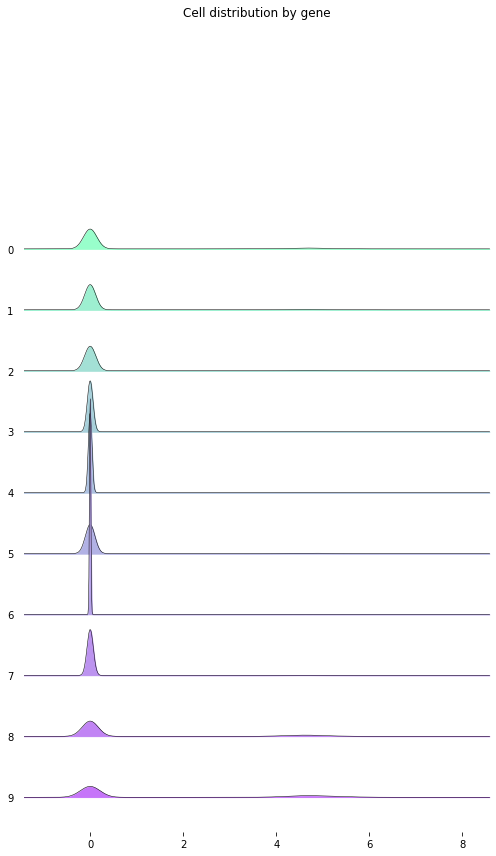

In [ ]:
df = pd.DataFrame(multi_targets[:,:10].toarray())
show_graph(df)

In [ ]:
targets_df = pd.DataFrame(multi_targets[:100,:10].toarray())
df.loc[df==0].count()/df.shape[1]

In [ ]:
gc.collect()
preds = np.load('/content/drive/MyDrive/kaggle/single-cell-competition/data/output/preds_x32y32.npy')
df = pd.DataFrame(preds[:,:10])
# show_graph(df)

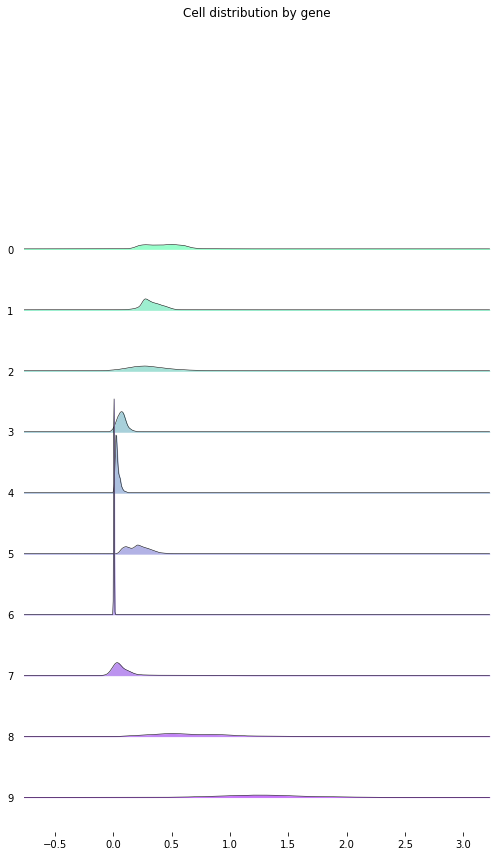

In [ ]:
show_graph(df)